In [1]:
# Import modules
import requests
import re, spacy
from collections import defaultdict
import pandas as pd
import numpy as np
import itertools
import pickle
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import MultipleLocator
%matplotlib inline

def get_book(url):
  # Make the request
  r = requests.get(url)
  # Get the text
  book = r.text
  return book

# Store url
url_the_circular_staircase = 'http://www.gutenberg.org/cache/epub/434/pg434.txt'
url_the_window_at_the_white_cat = 'http://www.gutenberg.org/cache/epub/34020/pg34020.txt'
url_the_case_of_jennie_brice = 'http://www.gutenberg.org/cache/epub/11127/pg11127.txt'
url_the_after_house = 'http://www.gutenberg.org/cache/epub/2358/pg2358.txt'
# url_a_poor_wise_man = 'http://www.gutenberg.org/files/1970/1970-0.txt'
url_the_man_in_lower_ten = 'http://www.gutenberg.org/files/1869/1869-0.txt'
book1 = get_book(url_the_circular_staircase)
book2 = get_book(url_the_man_in_lower_ten)
book3 = get_book(url_the_window_at_the_white_cat)
book4 = get_book(url_the_case_of_jennie_brice)
book5 = get_book(url_the_after_house)
# book5 = get_book(url_a_poor_wise_man)


In [2]:
def content_extractor(book, end_of_project = True):
  if end_of_project:
    pattern = ("(CHAPTER (?:[A-Z-][ ]){2,}[A-Z]|"
              "CHAPTER)\s+" +                           # Group 1 selects the chapter string
              "([A-Z \n',.-]+)\\b(?![A-Z]+(?=\.)\\b)" + # Group 2 selects the chapter number but excludes all caps word beginning title of the chapter
              "([A-Z \r\n'\",.!?-]+[\r\n])" +            # Group 3 selects the chapter title 
              "(?![a-z']|[A-Z.])" +                     # Chapter title ends before lowercase letters or a period
              "(.*?)" +                                 # Group 4 selects the chapter contents
              "(?=CHAPTER (?:[A-Z][ ]){2,}|"
              "THE\s+END\s+|"
              "End\s+of\s+Project\s+|"
              "CHAPTER)")                               # chapter contents ends with a new chapter or the end of book
  else: 
    pattern = ("(CHAPTER (?:[A-Z-][ ]){2,}[A-Z]|"
              "CHAPTER)\s+" +                           
              "([A-Z \n',.-]+)\\b(?![A-Z]+(?=\.)\\b)" + 
              "([A-Z \r\n'\",.!?-]+[\r\n])" +            
              "(?![a-z']|[A-Z.])" +                     
              "(.*?)" +                                 
              "(?=CHAPTER (?:[A-Z][ ]){2,}|"
              "THE\s+END\s+|"
              "End\s+of\s+the\s+Project\s+|"
              "CHAPTER)")                               
  
  chapters = re.findall(pattern, book, re.DOTALL)
  text = []
  for chapter in chapters:
    chap_title = chapter[2].replace('\r', '')
    chap_title = chap_title.replace('\n', ' ')
    chap_text = chapter[3]
    chap_text = chap_text.replace('â\x80\x9c', '\"')
    chap_text = chap_text.replace('â\x80\x9d', '\"')
    chap_text = chap_text.replace('\r', '')
    chap_text = chap_text.replace('\n', ' ')
    chap_text = re.sub('\n*; [0-9]; \n*' + chap_title + ' \n*', '', chap_text, flags=re.IGNORECASE)
    if end_of_project:
     chap_text = re.sub('\n*; [0-9];\s*(CHAPTER [A-Z-]+\s*)|(End\s+of\s+Project\s+)\s*', '', chap_text)
    else:
     chap_text = re.sub('\n*; [0-9];\s*(CHAPTER [A-Z-]+\s*)|(End\s+of\s+the\s+Project\s+)\s*', '', chap_text)
    chap_text = re.sub(' \n*; [0-9]; \n*', '', chap_text)
    chap_text = re.sub('\s*'.join([word for word in chap_title.split()]), '', chap_text)
    text.append(chap_text)
  text = '.'.join(text)
  return text

# content_extractor(book)

In [3]:
doc1 = content_extractor(book1)
doc2 = content_extractor(book2, False)
doc3 = content_extractor(book3)
doc4 = content_extractor(book4)
doc5 = content_extractor(book5)

def pos_counter(doc):
  nlp = spacy.load("en_core_web_sm")
  doc = nlp(doc)
  noun = 0
  verb = 0
  propn = 0
  adj = 0
  adv = 0
  for token in doc:
    if token.pos_=="NOUN":
      noun+=1 
    elif token.pos_=="VERB":
      verb+=1
    elif token.pos_=="ADJ":
      adj+=1
    elif token.pos_=="ADV":
      adv+=1
    elif token.pos_=="PROPN":
      # print(token.text, token.pos_)
      propn+=1
  print('__________________________________________')
  print("Number of Verbs in the text = ",verb)
  print("Number of Nouns in the text = ",noun)
  print("Number of Proper Nouns in the text = ",propn)
  print("Number of Adjectives in the text = ",adj)
  print("Number of Adverbs in the text = ",adv)
  return noun, verb, adj, adv


In [4]:
def plot_pos(novel_ls):
  x_pos = [i for i, _ in enumerate(novel_ls)]
  index = pd.Index(x_pos, name='Rinehart Novels')
  data = {'NOUN': (noun1,noun2,noun3,noun4,noun5), 
          'VERB': (verb1,verb2,verb3,verb4,verb5),
          'ADJECTIVE': (adj1,adj2,adj3,adj4,adj5),
          'ADVERB': (adv1,adv2,adv3,adv4,adv5)}
  df = pd.DataFrame(data, index=index)
  ax = df.plot(kind='barh', stacked=True, figsize = (8,6))
  ax.set_xlabel('\nTagged Parts of Speech Count', fontsize=20)
  ax.set_ylabel('Rinehart Novels\n', fontsize=20)
  plt.minorticks_on()
  plt.yticks(x_pos, novel_ls)
  plt.rc('xtick', labelsize=15) 
  plt.rc('ytick', labelsize=15) 
  plt.title("Parts of Speech Distribution in Each Novel", fontsize=20)
  plt.legend(title='labels', loc='best')
  plt.show()



# Find entities in novels using regex


In [5]:
pattern = ("[A-Z][a-z]+,?\s+(?:[A-Z][a-z]*\.?\s*)?[A-Z][a-z]+")
names1 = re.findall(pattern, doc1)
names2 = re.findall(pattern, doc2)
names3 = re.findall(pattern, doc3)
names4 = re.findall(pattern, doc4)
names5 = re.findall(pattern, doc5)

# print('NOVEL 1: ',np.unique(np.array(names1)))
# print('NOVEL 2: ',np.unique(np.array(names2)))
# print('NOVEL 3: ',np.unique(np.array(names3)))
# print('NOVEL 4: ',np.unique(np.array(names4)))
# print('NOVEL 5: ',np.unique(np.array(names5)))


# Divide each novel into chapters

In [6]:
# utility function for chapter seperator
def slicer(my_str,sub):
  index=my_str.find(sub)
  if index !=-1 :
    return [my_str[:index], my_str[index:]] 
  else :
    raise Exception('Sub string not found!')


def man_in_lower_ten_chapters(book):
  pattern = ("(CHAPTER)"
            "(.*?)" +                                 
            "(?=CHAPTER (?:[A-Z][ ]){2,}|"
            "THE\s+END\s+|"
            "End\s+of\s+Project\s+|"
            "CHAPTER)") 
  chapter_dict = defaultdict(dict)
  chapter_ls = re.findall(pattern, book, re.DOTALL)
  chapters = []
  for chapter in chapter_ls:
    ch_nt, ch_c = slicer(chapter[1],'\r')
    ch_n, ch_t = slicer(ch_nt,'. ')
    chapters.append([chapter[0], ch_n, ch_t, ch_c])
  return chapters


In [7]:
def chapter_separator(book, end_of_project = True, man_in_lower_ten = False):
  if end_of_project:
    pattern = ("(CHAPTER)\s+" +                         # Group 1 selects the chapter string
              "([A-Z \n',.-]+)\\b(?![A-Z]+(?=\.)\\b)" + # Group 2 selects the chapter number but excludes all caps word beginning title of the chapter
              "([A-Z \r\n'\",.!?-]+[\r\n])" +           # Group 3 selects the chapter title 
              "(?![a-z']|[A-Z.])" +                     # Chapter title ends before lowercase letters
              "(.*?)" +                                 # Group 4 selects the chapter contents
              "(?=CHAPTER (?:[A-Z][ ]){2,}|"
              "THE\s+END\s+|"
              "End\s+of\s+Project\s+|"
              "CHAPTER)")                               # chapter contents ends with a new chapter or the end of book
  else: 
    pattern = ("(CHAPTER)\s+" +                           
              "([A-Z \n',.-]+)\\b(?![A-Z]+(?=\.)\\b)" + 
              "([A-Z \r\n'\",.!?-]+[\r\n])" +            
              "(?![a-z']|[A-Z.])" +                     
              "(.*?)" +                                 
              "(?=CHAPTER (?:[A-Z][ ]){2,}|"
              "THE\s+END\s+|"
              "End\s+of\s+the\s+Project\s+|"
              "CHAPTER)")                               
  
  chapter_dict = defaultdict(dict)
  if man_in_lower_ten:
    chapters = man_in_lower_ten_chapters(book)
  else:
    chapters = re.findall(pattern, book, re.DOTALL)
  c = 1
  for chapter in chapters:
    chap_num = chapter[0] + " " + str(c)
    chap_title = chapter[2].replace('\r', '')
    chap_title = chap_title.replace('\n', ' ')
    chap_text = chapter[3]
    chap_text = chap_text.replace('â\x80\x9c', '\"')
    chap_text = chap_text.replace('â\x80\x9d', '\"')
    chap_text = chap_text.replace('â', '\"')
    chap_text = chap_text.replace('â', '\"')
    chap_text = chap_text.replace('\r', '')
    chap_text = chap_text.replace('\n', ' ')
    chap_text = re.sub('\n*; [0-9]; \n*' + chap_title + ' \n*', '', chap_text, flags=re.IGNORECASE)
    if end_of_project:
     chap_text = re.sub('\n*; [0-9];\s*(CHAPTER [A-Z-]+\s*)|(End\s+of\s+Project\s+)\s*', '', chap_text)
    else:
     chap_text = re.sub('\n*; [0-9];\s*(CHAPTER [A-Z-]+\s*)|(End\s+of\s+the\s+Project\s+)\s*', '', chap_text)
    chap_text = re.sub(' \n*; [0-9]; \n*', '', chap_text)
    chap_text = re.sub('\s*'.join([word for word in chap_title.split()]), '', chap_text)
    chapter_dict[chap_num] = (chap_title, chap_text)
    c+=1
  chapter_dict = dict(chapter_dict)
  return chapter_dict

print(len(chapter_separator(book2, True, True)))


31


# Plot number of chapters in each novel

In [8]:
def plot_novel_size(novel_ls, chap):
  # plt.style.use('ggplot')
  figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
  x_pos = [i for i, _ in enumerate(novel_ls)]
  plt.barh(x_pos, chap, color='green')
  plt.xlabel("\nChapter Count", fontsize=20)
  plt.ylabel("Rinehart Novels\n", fontsize=20)
  plt.title("Chapter Count in Each Novel", fontsize=20)
  plt.minorticks_on()
  plt.yticks(x_pos, novel_ls)
  plt.rc('xtick', labelsize=20) 
  plt.rc('ytick', labelsize=20) 
  plt.show()
  

# Divide each chapter into sentences

In [9]:
def sentence_tokenizer(text):
  alphabets= "([A-Za-z])"
  start = "([A-Z])"
  prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
  suffixes = "(Inc|Ltd|Jr|Sr|Co)"
  starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
  acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
  websites = "[.](com|net|org|io|gov)"
  text = text.replace("'s", "")
  text = text.replace("o'", "of the")
  text = text.replace("can't", "can not")
  text = text.replace("don't", "do not")
  text = text.replace("didn't", "did not")
  text = text.replace("wasn't", "was not")
  text = text.replace("'m", " am")
  text = text.replace("'ll", " will")
  text = text.replace("_", "")
  text = text.replace("\n","")
  text = text.replace("\r","")
  text = re.sub(prefixes,"\\1<prd>",text)
  text = re.sub(websites,"<prd>\\1",text)
  if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
  text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
  text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
  text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
  text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
  text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
  text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
  text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
  if "”" in text: text = text.replace(".”","”.")
  text = text.replace(".",".<stop>")
  text = text.replace(". ",".<stop>")
  text = text.replace("<prd>",".")
  sentences = text.split("<stop>")
  sentences = [s.strip() for s in sentences]
  return sentences


In [10]:
def doc_to_sentence(d):
  cont_dict = defaultdict(dict)
  for key,val in d.items():
    # print("VAL: ", val[1])
    token = sentence_tokenizer(val[1])    
    # print("TOKEN: ", token)
    cont_dict[key] = token
  cont_dict = dict(cont_dict)
  return cont_dict


# Divide each sentence into words

In [11]:
def word_tokenizer(tokenized_sent_dict):
  word_list = []
  sentences = []
  for k, v in tokenized_sent_dict.items():
    for s in v:
      sentences.append(s)
  for s in sentences:
    s = re.split(' |\--', s)
    w_list = []
    for w in s:
      w = w.lower()
      w = re.sub('[,"\.\'&\|:@>*;/=?!\']', "", w)
      w = re.sub('^[0-9\.]*$', "", w)
      w_list.append(w)
    while("" in w_list): 
      w_list.remove("") 
    word_list.append(w_list)
  # print(word_list)
  return word_list


# Functions to answer the following questions:

  * When does the **detective (or a pair) occur for the first time** -  chapter #, the sentence(s) # in a chapter
  * When is the **crime first mentioned** - the type of the crime and the details -  chapter #, the sentence(s) # in a chapter
  * When is the **perpetrator first mentioned** - chapter #, the sentence(s) # in a chapter
  * What are the **3 words that occur around the perpetrator** on each mention (i.e., the three words preceding, and the three words following the mention of a perpetrator)
  * When and how the **detective/detectives and the perpetrators co-occur** - chapter #, the sentence(s) # in a chapter
  * When are **other suspects first introduced** - chapter #, the sentence(s) # in a chapter



In [12]:
def word_counter(tokenized_sent_dict, word, crime=False):
  """takes in the dictionary of sentences in a novel 
      where key is the chapter number and values are the sentences 
      and returns a dictionary where the key is a tuple of chapter 
      number and sentence number and value is either 0(not exist) or 1(exists)
      depending on the appearance of the given word(s) in a sentence""" 
  ls = []
  counter_dict = defaultdict(dict)
  e = '[^a-zA-Z]'
  for k, v in tokenized_sent_dict.items():
    # initiate sentence counter
    i = 0
    for s in list(v):
      if type(word) is list:
        if len(word) == 2:
          if re.findall(e+word[0]+e, s, flags=re.IGNORECASE) or\
              re.findall(e+word[1]+e, s, flags=re.IGNORECASE):
            counter_dict[(k, i)] = 1
          else:
            counter_dict[(k, i)] = 0
        elif len(word) == 3:
          if re.findall(e+word[0]+e, s, flags=re.IGNORECASE) or\
              re.findall(e+word[1]+e, s, flags=re.IGNORECASE) or\
              re.findall(e+word[2]+e, s, flags=re.IGNORECASE):
            counter_dict[(k, i)] = 1
          else:
            counter_dict[(k, i)] = 0
        elif len(word) == 5:
          if re.findall(e+word[0]+e, s, flags=re.IGNORECASE) or\
              re.findall(e+word[1]+e, s, flags=re.IGNORECASE) or\
              re.findall(e+word[2]+e, s, flags=re.IGNORECASE) or\
              re.findall(e+word[3]+e, s, flags=re.IGNORECASE) or\
              re.findall(e+word[4]+e, s, flags=re.IGNORECASE):
            counter_dict[(k, i)] = 1
          else:
            counter_dict[(k, i)] = 0
      else:
        if crime:
          # make sure all forms of verbs are captured
          l = len(re.findall(word, s, flags=re.IGNORECASE))
        else:
          l = len(re.findall(e+word+e, s, flags=re.IGNORECASE))
        counter_dict[(k, i)] = l
      i += 1
  counter_dict = dict(counter_dict)
  total_ct = sum(list(counter_dict.values()))
  for k, v in counter_dict.items():
    if v != 0:
      ls.append(k)
  return counter_dict, ls, total_ct


In [13]:
def first_mention_finder(tokenized_sent_dict, w, crime=False):
  """takes in the dictionary of sentences in a novel 
      where key is the chapter number and values are the sentences 
      and returns a dictionary where the key is a tuple of chapter 
      number and sentence number and value is the first chapter and 
      sentence given word(s) appeared in a sentence"""  
  counter_dict = defaultdict(dict)
  e = '[^a-zA-Z]'
  for k, v in tokenized_sent_dict.items():
    # initiate sentence counter
    i = 0
    for s in list(v):
      if len(w) == 1:
        if not crime:
         l = len(re.findall(e+w[0]+e, s, flags=re.IGNORECASE))
        else:
        # to make sure that the verbs in all forms are captured in the search
         l = len(re.findall(w[0], s, flags=re.IGNORECASE))
        counter_dict[(k, i)] = l
      else:
        if re.findall(e+w[0]+e, s, flags=re.IGNORECASE)and \
          re.findall(e+w[1]+e, s, flags=re.IGNORECASE):
          counter_dict[(k, i)] = 1
        else:
          counter_dict[(k, i)] = 0
      i += 1

  counter_dict = dict(counter_dict)
  total_ct = sum(list(counter_dict.values()))
  for k, v in counter_dict.items():
    while v != 0:
      return k


In [14]:
def cooccurence_finder(tokenized_sent_dict, word1, word2):
  """takes in the dictionary of sentences in a novel 
      where key is the chapter number and values are the sentences 
      and returns a dictionary where the key is a tuple of chapter number and sentence number 
      and value is 0/1 depending on the appearance of word-couple in a sentence"""  
  coocur_dict = defaultdict(dict)
  e = '[^a-zA-Z]'
  for k, v in tokenized_sent_dict.items():
    # initiate sentence counter
    i = 0
    for s in list(v):
      if re.findall(e+word1+e, s, flags=re.IGNORECASE) and \
         re.findall(e+word2+e, s, flags=re.IGNORECASE):
         coocur_dict[(k, i)] = 1
      else:
        coocur_dict[(k, i)] = 0
      i += 1

  coocur_dict = dict(coocur_dict)
  occur_dict = defaultdict(dict)
  for k, v in coocur_dict.items():
    if v == 1:
      occur_dict[k] = v
    else:
      pass
  return occur_dict


In [15]:
def search_nbd(target, text, context=6):
  """takes in target word and the document 
      and returns the surrounding context of the given word
      in that document"""
  words = re.findall('\w+', text)
  matches = (i for (i,w) in enumerate(words) if w.lower() == target)
  for index in matches:
      if index < context //2:
          yield words[0:context+1]
      elif index > len(words) - context//2 - 1:
          yield words[-(context+1):]
      else:
          yield words[index - context//2:index + context//2 + 1]

def neighborhood_search(sent_dict, word, n):
  """Searches for text, and retrieves n/2 words on 
      each side of the text"""
  nbd_dict = defaultdict(dict)
  for k, v in sent_dict.items():
    sentences = []
    for s in v:
      sentences.append(s)
    sent = '.'.join(sentences)
    neighboring_wds = list(search_nbd(word, sent, n))
    if len(neighboring_wds) != 0:
      nbd_dict[k] = (word, neighboring_wds)
  nbd_dict = dict(nbd_dict)
  return nbd_dict


In [16]:
# plot wordcloud
def generate_wordcloud(word_list):
  w_list = []
  for wl in word_list:
    for w in wl:
      w_list.append(w)
  long_string = ','.join(w_list)
  # Create a WordCloud object
  wc = WordCloud(background_color="white", max_words=5000, 
                        contour_width=3, contour_color='steelblue')
  # Generate a word cloud
  wc.generate(long_string)
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.tight_layout(pad=0)
  plt.show() 

In [17]:
# extract details of crime
def crime_details_extractor(tokenized_sent_dict, ls):
  lst = list(itertools.chain.from_iterable(ls))
  sent_ls = []
  for l in lst:
    for k,v in tokenized_sent_dict.items():
      i = 0
      for s in v:
        if k==l[0] and i == l[1]:
          sent_ls.append(s)
        i+=1
  return sent_ls


In [18]:
# how the detective/detectives and the perpetrators co-occur
def det_perp_cooccur(tokenized_sent_dict, cooccur_tuple):
  for k,v in tokenized_sent_dict.items():
    i = 0
    for s in v:
      if cooccur_tuple[0] == k and cooccur_tuple[1] == i:
        sent = s
      i += 1
  return sent
 

In [19]:
# plot frequency distribution of detective, perpetrator and crime mentioned
def make_df(d_ls, head_ls):
  ch = []
  se = []
  for k,v in d_ls[0].items():
    ch.append(k[0])
    se.append(k[1])
  a = []

  for i in range(len(d_ls)):
    b = []
    for k,v in d_ls[i].items():
      if v != 0:
        b.append('Exist')
      else:
        b.append('Doesn\'t Exist')
    a.append(b)
  
  d = defaultdict(dict)
  for i in range(len(a)):
    d['Chapter'] = ch
    d['Sentence'] = se
    d[head_ls[i]] = a[i] 
  d = dict(d)

  df = pd.DataFrame(d)
  return df

def plot_freq_dist(df, z, title):
  groups = df.groupby(z)
  fig, ax = plt.subplots(figsize=(15, 10))
  # fig, ax = plt.subplots(figsize=(20, 10))
  for name, group in groups:
    if name == 'Exist':
      ax.plot(group.Chapter, group.Sentence, marker='o', linestyle='', color = 'r', 
              ms=10, label=name)
    else:
      ax.plot(group.Chapter, group.Sentence, marker='o', linestyle='', color = 'r', 
              ms=0, label=name)

  ax.legend(numpoints=1, loc='upper left')
  plt.xlabel("\nChapters", fontsize=20)
  plt.ylabel("Sentences\n", fontsize=20)
  plt.title("Frequency Distribution of " + title, fontsize=25)
  plt.minorticks_on()
  plt.rc('xtick', labelsize=20) 
  plt.rc('ytick', labelsize=20) 
  plt.xticks(rotation = 90)
  plt.show()


# Result Simulation

In [20]:
d1 = chapter_separator(book1)
d2 = chapter_separator(book2, True, True)
d3 = chapter_separator(book3, False)
d4 = chapter_separator(book4)
d5 = chapter_separator(book5)

s1 = doc_to_sentence(d1)
s2 = doc_to_sentence(d2)
s3 = doc_to_sentence(d3)
s4 = doc_to_sentence(d4)
s5 = doc_to_sentence(d5)



In [21]:
noun1, verb1, adj1, adv1 = pos_counter(doc1)
noun2, verb2, adj2, adv2 = pos_counter(doc2)
noun3, verb3, adj3, adv3 = pos_counter(doc3)
noun4, verb4, adj4, adv4 = pos_counter(doc4)
noun5, verb5, adj5, adv5 = pos_counter(doc5)

__________________________________________
Number of Verbs in the text =  10300
Number of Nouns in the text =  11398
Number of Proper Nouns in the text =  3940
Number of Adjectives in the text =  3634
Number of Adverbs in the text =  4682
__________________________________________
Number of Verbs in the text =  9491
Number of Nouns in the text =  10656
Number of Proper Nouns in the text =  2060
Number of Adjectives in the text =  3417
Number of Adverbs in the text =  4244
__________________________________________
Number of Verbs in the text =  10166
Number of Nouns in the text =  11152
Number of Proper Nouns in the text =  2905
Number of Adjectives in the text =  3639
Number of Adverbs in the text =  4327
__________________________________________
Number of Verbs in the text =  5533
Number of Nouns in the text =  5694
Number of Proper Nouns in the text =  2179
Number of Adjectives in the text =  1626
Number of Adverbs in the text =  2153
__________________________________________
Numb

In [22]:
novel_ls = ['The Circular Staircase (1908)','The Man in Lower Ten (1909)', 'The Window at the White Cat (1910)', 
              'The Case of Jennie Brice (1913)', 'The After House (1914)']



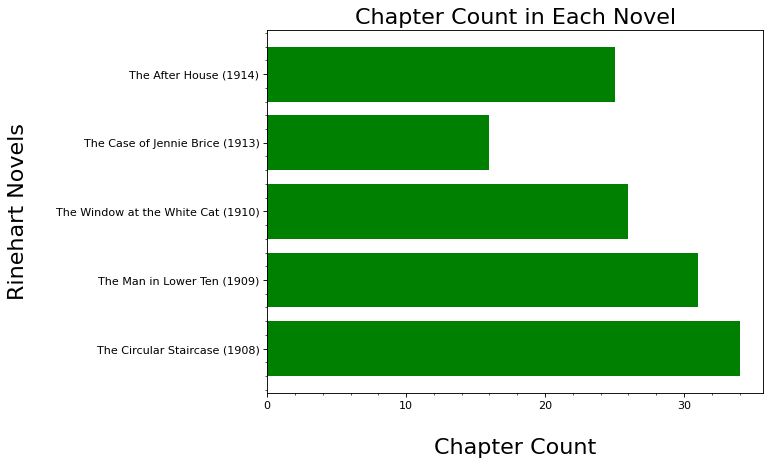

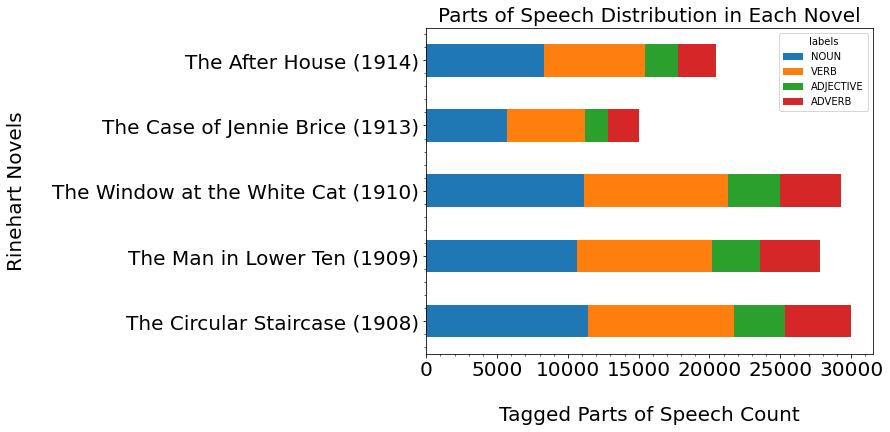

In [23]:
plot_novel_size(novel_ls, [len(d1),len(d2),len(d3),len(d4),len(d5)])
plot_pos(novel_ls)
 



In [24]:
word_list1 = word_tokenizer(s1)
word_list2 = word_tokenizer(s2)
word_list3 = word_tokenizer(s3)
word_list4 = word_tokenizer(s4)
word_list5 = word_tokenizer(s5)

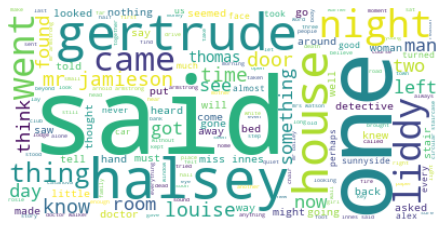

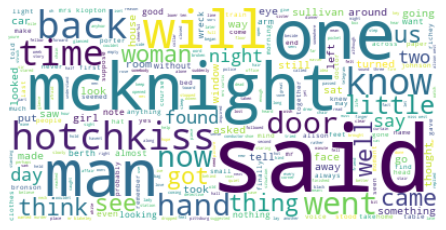

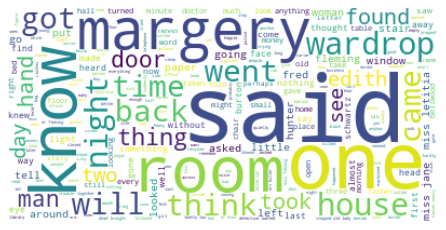

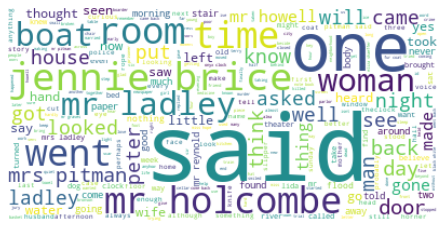

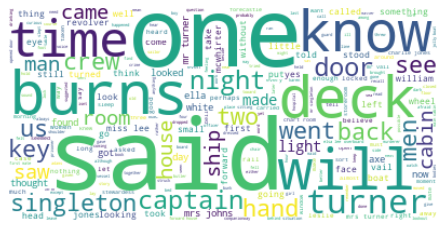

In [25]:
generate_wordcloud(word_list1) #novel-1
generate_wordcloud(word_list2) #novel-2
generate_wordcloud(word_list3) #novel-3
generate_wordcloud(word_list4) #novel-4
generate_wordcloud(word_list5) #novel-5

In [26]:
def first_list(s, n, crime = False):
  ls = []
  for d in n:
    ls.append([first_mention_finder(s, d, crime),d])
  print(ls)
  return ls 

In [27]:
# # When does the detective (or a pair) occur for the first time
# novel1_det = [['Rachel'], ['Jamieson'], ['Rachel','Jamieson']]
# novel3_det = [['Knox'], ['Jack']]
# novel4_det = [['Pitman'], ['Holcombe'], ['Pitman','Holcombe']]
# novel5_det = [['Leslie'], ['Ralph']]
# novel2_det = [['Lawrence'], ['Blakeley'], ['Wilson'], ['Budd'], ['Hotchkiss'], 
#               ['Lawrence','Hotchkiss'], ['Blakeley','Hotchkiss'], 
#               ['Lawrence','Wilson'], ['Blakeley','Wilson'], 
#               ['Lawrence','Budd'], ['Blakeley','Budd']]

# det1 = first_list(s1, novel1_det)
# det2 = first_list(s2, novel2_det)
# det3 = first_list(s3, novel3_det)
# det4 = first_list(s4, novel4_det)
# det5 = first_list(s5, novel5_det)

detectives = ['Frank Jamieson & Rachel Innes', 'Lawrence Blakeley & Wilson Budd Hotchkiss', 'Mr. Jack Knox', 'Mrs. Pitman & Mr. Holcombe',
              'Ralph Leslie']
fist_det_ch = ['CHAPTER 1', 'CHAPTER 1', 'CHAPTER 1', 'CHAPTER 1', 'CHAPTER 1']
fist_det_se = ['SENTENCE 10', 'SENTENCE 104', 'SENTENCE 60', 'SENTENCE 3', 'SENTENCE 51']
data_det = {'NOVEL NAME':novel_ls, 'DETECTIVE NAME(S)':detectives, 'CHAPTER NO':fist_det_ch, 
        'SENTENCE NO':fist_det_se}
df_det = pd.DataFrame(data_det)
df_det
# def first_mention_df_maker(novel_ls, all_novel_dict):
#   f1 = first_mention_finder(all_novel_dict[0])
#   f2 = first_mention_finder(all_novel_dict[1])
#   f3 = first_mention_finder(all_novel_dict[2])
#   f4 = first_mention_finder(all_novel_dict[3])
#   f5 = first_mention_finder(all_novel_dict[4])
#   chap_ls = [f1[0], f2[0], f3[0], f4[0], f5[0]]
#   sent_ls = ['SENTENCE '+ str(x) for x in [f1[1], f2[1], f3[1], f4[1], f5[1]]]
#   data = {'NOVEL NAME':novel_ls, 'CHAPTER NO':chap_ls, 'SENTENCE NO':sent_ls}
#   df = pd.DataFrame(data)
#   return df

,NOVEL NAME,DETECTIVE NAME(S),CHAPTER NO,SENTENCE NO
0,The Circular Staircase (1908),Frank Jamieson & Rachel Innes,CHAPTER 1,SENTENCE 10
1,The Man in Lower Ten (1909),Lawrence Blakeley & Wilson Budd Hotchkiss,CHAPTER 1,SENTENCE 104
2,The Window at the White Cat (1910),Mr. Jack Knox,CHAPTER 1,SENTENCE 60
3,The Case of Jennie Brice (1913),Mrs. Pitman & Mr. Holcombe,CHAPTER 1,SENTENCE 3
4,The After House (1914),Ralph Leslie,CHAPTER 1,SENTENCE 51


In [28]:
# # When is the crime first mentioned
# novel1_cr = [['murder']]
# novel3_cr = [['shot'], ['shoot'], ['murder']]
# novel4_cr = [['murder']]
# novel5_cr = [['murder']]
# novel2_cr = [['murder']] 

# cr1 = first_list(s1, novel1_cr, True)
# cr2 = first_list(s2, novel2_cr, True)
# cr3 = first_list(s3, novel3_cr, True)
# cr4 = first_list(s4, novel4_cr, True)
# cr5 = first_list(s5, novel5_cr, True)

# print('\n\n')
crime = ['Murder', 'Murder', 'Murder', 'Murder', 'Murder']
fist_cr_ch = ['CHAPTER 2', 'CHAPTER 3', 'CHAPTER 5', 'CHAPTER 2', 'CHAPTER 6']
fist_cr_se = ['SENTENCE 17', 'SENTENCE 119', 'SENTENCE 101', 'SENTENCE 118', 'SENTENCE 12']
data_cr = {'NOVEL NAME':novel_ls, 'CRIME':crime, 'CHAPTER NO':fist_cr_ch, 
        'SENTENCE NO':fist_cr_se}
df_cr = pd.DataFrame(data_cr)
df_cr

,NOVEL NAME,CRIME,CHAPTER NO,SENTENCE NO
0,The Circular Staircase (1908),Murder,CHAPTER 2,SENTENCE 17
1,The Man in Lower Ten (1909),Murder,CHAPTER 3,SENTENCE 119
2,The Window at the White Cat (1910),Murder,CHAPTER 5,SENTENCE 101
3,The Case of Jennie Brice (1913),Murder,CHAPTER 2,SENTENCE 118
4,The After House (1914),Murder,CHAPTER 6,SENTENCE 12


In [29]:
_, cr1, cr_ct1 = word_counter(s1, 'murder', True) #novel-1
crime_details_extractor(s1,[cr1])

['I am not going to be murdered with my eyes shut.',
 '"  "If you\'re going to be murdered," I retorted, "it won\'t make any difference whether they are shut or open.',
 '"Get up," I said, "if you do not want to be murdered in your bed.',
 '"I think it is murder.',
 '"It is Arnold Armstrong," he said, looking at me oddly, "and he has been murdered in his father house.',
 'Where had Halsey gone? How had he gone, and when? Before the murder, no doubt, but who would believe that?  If either he or Jack Bailey had heard an intruder in the house and shot him--as they might have been justified in doing--why had they run away?  The whole thing was unheard of, outrageous, and--impossible to ignore.',
 'I could hear Thomas in the pantry, alternately wailing for Mr. Arnold, as he called him, and citing the tokens that had precursed the murder.',
 'Then, as clearly as I could, I related how, the night before, a shot had roused us; that my niece and I had investigated and found a body; that I did n

In [30]:
_, cr2, cr_ct2 = word_counter(s2, 'murder', True) #novel-2
crime_details_extractor(s2,[cr2])

['"The man been murdered!"',
 '"It is murder.',
 '"Find the man who skipped out with this gentleman clothes, and you\'ve probably got the murderer.',
 'In the interval the thief--murderer, too, perhaps--must have come back, discovered my error, and taken advantage of it to further his escape.',
 'The doctor was investigating the murdered man effects.',
 'And now, to get down to business, what is the name of our escaped thief and probable murderer?"  "How on earth do I know?" I demanded impatiently.',
 'If you keep on you will have a motive for the crime, and the murderer present place of hiding.',
 '"Murder and robbery in one night and on one car.',
 'The thought of what the loss of the notes meant was fast crowding the murder to the back of my mind.',
 '"Well," I said, trying to speak naturally, "doesn\'t that prove what I have been telling you? The man who committed the murder belonged to this berth, and made an exchange in some way after the crime.',
 '"Did the man who left you his 

In [31]:
_, cr3, cr_ct3 = word_counter(s3, 'murder', True) #novel-3
crime_details_extractor(s3,[cr3])

['The stain showed a hand somewhat short and broad, with widened finger-tips; marked in ink, it would not have struck me so forcibly, perhaps, but there, its ugly red against the white wood, it seemed to me to be the imprint of a brutal, murderous hand.',
 'You are certain there are no closets or unused rooms where, if there had been a murder, the body could be concealed.',
 '"It like where there smoke there fire; where there murder there a body.',
 'An especially malignant foe might rob, or even murder, but it was almost ludicrous to think of his carrying away by force Miss Jane ninety pounds of austere flesh.',
 '"It is murder, and I warn you, Mr. Wardrop, to be careful what you say.',
 'This is murder, not suicide.',
 '"Murder!" he repeated.',
 'I could not go back to Margery Fleming and tell her that her father had been murdered and her lover was accused of the crime.',
 '"  I think Wardrop was dazed at finding himself free; he had expected nothing less than an immediate charge of 

In [32]:
_, cr4, cr_ct4 = word_counter(s4, 'murder', True) #novel-4
crime_details_extractor(s4,[cr4])

['Although the idea of murder had not entered my head at that time, the slipper gave me a turn.',
 'I had made up my mind that there had been murder done.',
 '"It curious, but--you can not prove a murder unless you can produce a body.',
 '"We can not go to the police with a wet slipper and a blood-stained rope and accuse a man of murder.',
 '" And to Mr. Holcombe: "So, having found a wet slipper and a broken knife, you are prepared for murder and sudden death!"  "I have more evidence," Mr. Holcombe said eagerly, and proceeded to tell what we had found in the room.',
 '"Remember, Holcombe," he called, "every well-constituted murder has two things: a motive and a corpse.',
 'I think a woman from my house has been murdered, but I do not know.',
 '"  "Murdered," he said, and drew up his chair.',
 "It seems there isn't any murder when there isn't any corpse.",
 '"  "For murder?" I asked.',
 'Mr. Pitman had always read all the murder trials, and used to talk about the corpus delicti and writ

In [33]:
_, cr5, cr_ct5 = word_counter(s5, 'murder', True) #novel-5
crime_details_extractor(s5,[cr5])

['I lowered the revolver and gasped: "Call the captain!  Vail been murdered!  "Good God!" he said.',
 'Turner was lying on his bed, fully dressed, and at first I thought he too had been murdered.',
 '"Try to rouse yourself, man!  The captain has been murdered, and Mr. Vail!"  He made an effort to sit up, swayed, and fell back again.',
 'Somewhere on the Ella the murderer was loose.',
 'Among them, I felt sure, was the murderer.',
 '"Boys," I said, "Mr. Vail and your captain have been murdered.',
 'The murderer must be on the ship--one of ourselves.',
 '"  "Turner!  He has killed some one finally!"  "Hush, for Heaven sake!  Wilmer has been murdered, Adele--and the captain.',
 '"  "The murderer is still on the ship," I protested.',
 'Stains that might have been of invaluable service in determining the murderer were washed away almost before they were dry.',
 'But the axe remained, and I felt that its handle probably contained a record for more skillful eyes than mine to read, prints that

In [34]:
# # When is the perpetrator first mentioned
# novel1_pe = [['Anne'], ['Watson']]
# novel3_pe = [['Schwartz']]
# novel4_pe = [['Philip'], ['Ladley']]
# novel5_pe = [['Marshall'], ['Benedict'], ['Turner']]
# novel2_pe = [['Alice'], ['Curtis']]

# pe1 = first_list(s1, novel1_pe)
# pe2 = first_list(s2, novel2_pe)
# pe3 = first_list(s3, novel3_pe)
# pe4 = first_list(s4, novel4_pe)
# pe5 = first_list(s5, novel5_pe)

perp = ['Mrs. Anne Watson', 'Alice Curtis', 'Mr. Henry Schwartz', 'Philip Ladley', 'Marshall Benedict Turner']
fist_pe_ch = ['CHAPTER 1', 'CHAPTER 9', 'CHAPTER 1', 'CHAPTER 1', 'CHAPTER 1']
fist_pe_se = ['SENTENCE 37', 'SENTENCE 56', 'SENTENCE 203', 'SENTENCE 1', 'SENTENCE 89']
data_pe = {'NOVEL NAME':novel_ls, 'PERPETRATOR':perp, 'CHAPTER NO':fist_pe_ch, 
        'SENTENCE NO':fist_pe_se}
df_pe = pd.DataFrame(data_pe)
df_pe

,NOVEL NAME,PERPETRATOR,CHAPTER NO,SENTENCE NO
0,The Circular Staircase (1908),Mrs. Anne Watson,CHAPTER 1,SENTENCE 37
1,The Man in Lower Ten (1909),Alice Curtis,CHAPTER 9,SENTENCE 56
2,The Window at the White Cat (1910),Mr. Henry Schwartz,CHAPTER 1,SENTENCE 203
3,The Case of Jennie Brice (1913),Philip Ladley,CHAPTER 1,SENTENCE 1
4,The After House (1914),Marshall Benedict Turner,CHAPTER 1,SENTENCE 89


In [35]:
# # When are other suspects first introduced
# novel1_su = [['Jack'], ['Bailey'], ['Halsey'], ['Paul'], ['Armstrong']]
# novel3_su = [['Harry'], ['Wardrop'], ['Clarkson'], ['Robert'], ['Allan'], ['Fleming']]
# novel4_su = [['Philip'], ['Ladley']]
# novel5_su = [['Oleson'], ['Adams'], ['Charlie'], ['Jones'], ['Clarke'], ['McNamara'], ['Williams']]
# novel2_su = [['Lawrence'], ['Blakeley']]

# su1 = first_list(s1, novel1_su)
# su2 = first_list(s2, novel2_su)
# su3 = first_list(s3, novel3_su)
# su4 = first_list(s4, novel4_su)
# su5 = first_list(s5, novel5_su)

novels = [novel_ls[0], '', '', novel_ls[1], novel_ls[2], '', '', novel_ls[3], novel_ls[4], 
          '', '', '', '', '']
susp = ['Jack Bailey', 'Halsey Innes', 'Paul Armstrong', 'Lawrence Blakeley','Harry Wardrop', 'Robert Clarkson',
        'Allan Fleming', 'Philip Ladley', 'Oleson', 'Adams', 'Charlie Jones', 'Clarke', 'McNamara', 
        'Williams']
fist_su_ch = ['CHAPTER 3', 'CHAPTER 1', 'CHAPTER 1', 'CHAPTER 1', 'CHAPTER 3', 
              'CHAPTER 5', 'CHAPTER 1', 'CHAPTER 1', 'CHAPTER 5', 'CHAPTER 5', 
              'CHAPTER 3', 'CHAPTER 6', 'CHAPTER 6', 'CHAPTER 3']
fist_su_se = ['SENTENCE 43', 'SENTENCE 13', 'SENTENCE 44', 'SENTENCE 104', 
              'SENTENCE 95', 'SENTENCE 154', 'SENTENCE 59', 'SENTENCE 1', 'SENTENCE 6',
              'SENTENCE 6', 'SENTENCE 111', 'SENTENCE 71', 'SENTENCE 71', 'SENTENCE 5']
data_su = {'NOVEL NAME':novels, 'SUSPECTS':susp, 'CHAPTER NO':fist_su_ch, 
        'SENTENCE NO':fist_su_se}
df_su = pd.DataFrame(data_su)
df_su

,NOVEL NAME,SUSPECTS,CHAPTER NO,SENTENCE NO
0,The Circular Staircase (1908),Jack Bailey,CHAPTER 3,SENTENCE 43
1,,Halsey Innes,CHAPTER 1,SENTENCE 13
2,,Paul Armstrong,CHAPTER 1,SENTENCE 44
3,The Man in Lower Ten (1909),Lawrence Blakeley,CHAPTER 1,SENTENCE 104
4,The Window at the White Cat (1910),Harry Wardrop,CHAPTER 3,SENTENCE 95
5,,Robert Clarkson,CHAPTER 5,SENTENCE 154
6,,Allan Fleming,CHAPTER 1,SENTENCE 59
7,The Case of Jennie Brice (1913),Philip Ladley,CHAPTER 1,SENTENCE 1
8,The After House (1914),Oleson,CHAPTER 5,SENTENCE 6
9,,Adams,CHAPTER 5,SENTENCE 6


In [36]:
# What are the 3 words that occur around the perpetrator on each mention
perpetrator_nbd1_1 = neighborhood_search(s1, 'watson', 6) #novel1
perpetrator_nbd1_2 = neighborhood_search(s1, 'anne', 6) #novel1

perpetrator_nbd3_1 = neighborhood_search(s3, 'henry', 6) #novel2
perpetrator_nbd3_2 = neighborhood_search(s3, 'schwartz', 6) #novel2

perpetrator_nbd4_1 = neighborhood_search(s4, 'philip', 6) #novel3
perpetrator_nbd4_2 = neighborhood_search(s4, 'ladley', 6) #novel3

perpetrator_nbd5_1 = neighborhood_search(s5, 'marshall', 6) #novel4
perpetrator_nbd5_2 = neighborhood_search(s5, 'benedict', 6)
perpetrator_nbd5_3 = neighborhood_search(s5, 'turner', 6)

perpetrator_nbd2_1 = neighborhood_search(s2, 'alice', 6) #novel5
perpetrator_nbd2_2 = neighborhood_search(s2, 'curtis', 6) #novel5


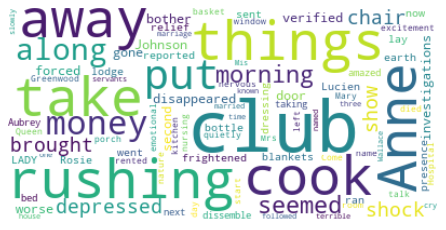

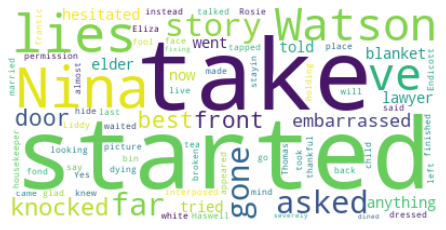

In [37]:
def nbd_cloud(nbd_ls, perp):
  nbd_wrd_ls = []
  for i in range(len(nbd_ls)):
    nbd = [v[1] for v in nbd_ls[i].values()]
    nbd_wrd_ls.append(nbd)
  
  first = []
  last = []
  for i in range(len(nbd_wrd_ls)):
    nbd = [e for sl in nbd_wrd_ls[i] for e in sl]
    first3 = [e[:3] for e in nbd]
    last3 = [e[4:] for e in nbd]
    first.append(first3)
    last.append(last3)
  words_first3_nbd = [e for sl in first for e in sl]
  words_last3_nbd = [e for sl in last for e in sl]
  generate_wordcloud(words_first3_nbd, perp)
  generate_wordcloud(words_last3_nbd, perp)

# plot wordcloud
def generate_wordcloud(word_list, perp):
  w_list = []
  for wl in word_list:
    for w in wl:
      w_list.append(w)
  w_list = list(set(w_list)-set(perp))
  long_string = ','.join(w_list)
  # Create a WordCloud object
  wc = WordCloud(background_color="white", max_words=5000, 
                        contour_width=3, contour_color='steelblue')
  # Generate a word cloud
  wc.generate(long_string)
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.tight_layout(pad=0)
  plt.show() 


nbd_cloud([perpetrator_nbd1_1, perpetrator_nbd1_2], ['anne', 'watson'])

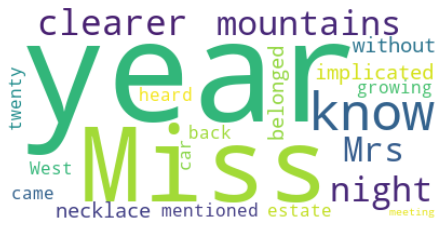

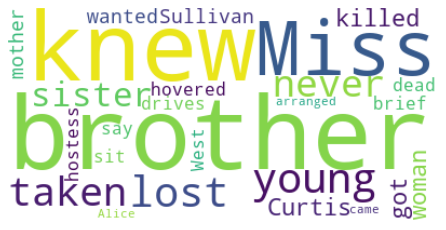

In [38]:
nbd_cloud([perpetrator_nbd2_1, perpetrator_nbd2_2], ['alice', 'curtis'])

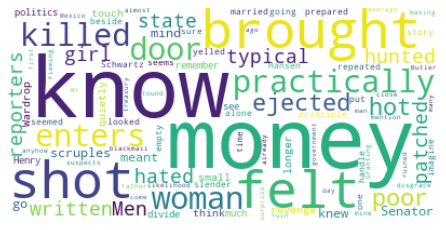

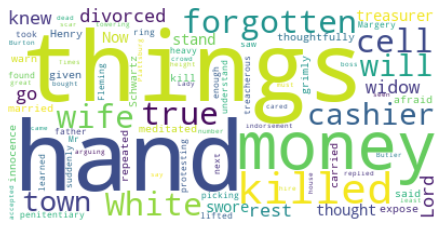

In [39]:
nbd_cloud([perpetrator_nbd3_1, perpetrator_nbd3_2], ['henry', 'schwartz'])

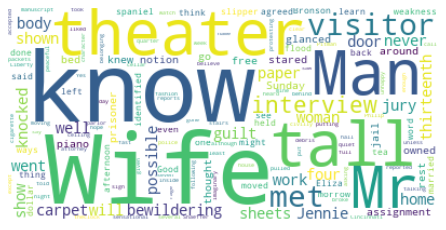

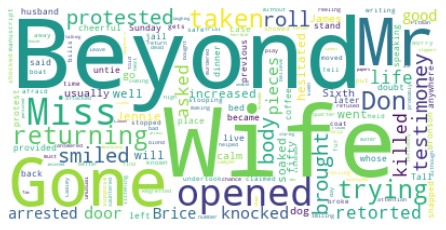

In [40]:
nbd_cloud([perpetrator_nbd4_1, perpetrator_nbd4_2], ['philip', 'ladley'])

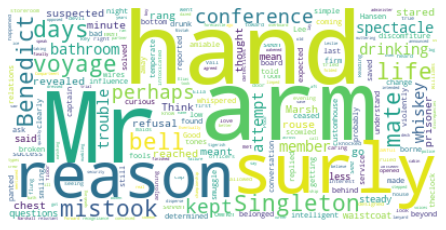

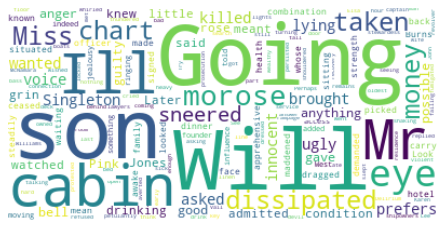

In [41]:
nbd_cloud([perpetrator_nbd5_1, perpetrator_nbd5_2, perpetrator_nbd5_3],['marshall', 'benedict', 'turner'] )

In [42]:
print(perpetrator_nbd1_1, perpetrator_nbd1_2)

{'CHAPTER 2': ('watson', [['name', 'was', 'Anne', 'Watson', 'and', 'I', 'dined']]), 'CHAPTER 4': ('watson', [['up', 'and', 'Anne', 'Watson', 'who', 'had', 'waited'], ['cry', 'and', 'Mrs', 'Watson', 'knocked', 'over', 'a'], ['relief', 'when', 'Mrs', 'Watson', 'tapped', 'at', 'the'], ['the', 'house', 'Mrs', 'Watson', 'herself', 'was', 'a'], ['talk', 'with', 'Mrs', 'Watson', 'and', 'I', 'dressed']]), 'CHAPTER 6': ('watson', [['went', 'in', 'Mrs', 'Watson', 'appeared', 'at', 'the'], ['Come', 'in', 'Mrs', 'Watson', 'the', 'lawyer', 'said']]), 'CHAPTER 7': ('watson', [['the', 'start', 'Mrs', 'Watson', 'went', 'into', 'her'], ['and', 'depressed', 'Mrs', 'Watson', 'and', 'Liddy', 'were'], ['nursing', 'bottle', 'Mrs', 'Watson', 'was', 'fixing', 'a']]), 'CHAPTER 8': ('watson', [['went', 'away', 'Mis', 'Watson', 'an', 'me', 'we'], ['was', 'rented', 'Mis', 'Watson', 'she', 've', 'bin'], ['one', 'day', 'Mis', 'Watson', 'she', 'came', 'to'], ['up', 'with', 'Mis', 'Watson', 'stayin', 'in', 'the'], ['

In [43]:
print(perpetrator_nbd2_1, perpetrator_nbd2_2)

{'CHAPTER 24': ('alice', [['I', 'know', 'the', 'Alice', 'sit', 'by', 'the'], ['It', 'was', 'not', 'Alice', 'sit', 'by', 'the']]), 'CHAPTER 30': ('alice', [['necklace', 'belonged', 'to', 'my', 'sister', 'Alice', 'Curtis']])} {'CHAPTER 9': ('curtis', [['you', 'mentioned', 'Mrs', 'Curtis', 'was', 'my', 'hostess']]), 'CHAPTER 13': ('curtis', [['West', 'and', 'Mrs', 'Curtis', 'had', 'taken', 'the']]), 'CHAPTER 23': ('curtis', [['Miss', 'West', 'Mrs', 'Curtis', 'and', 'Sullivan', 'The']]), 'CHAPTER 24': ('curtis', [['estate', 'since', 'Mrs', 'Curtis', 'was', 'killed', 'No'], ['twenty', 'years', 'Mrs', 'Curtis', 'wanted', 'her', 'brother'], ['have', 'heard', 'Mrs', 'Curtis', 'say', 'her', 'mother'], ['not', 'like', 'Mrs', 'Curtis', 'I', 'wanted', 'to'], ['came', 'back', 'Mrs', 'Curtis', 'is', 'dead', 'You'], ['car', 'with', 'Mrs', 'Curtis', 'Miss', 'West', 'and']]), 'CHAPTER 28': ('curtis', [['meeting', 'with', 'the', 'Curtis', 'woman', 'was', 'brief'], ['a', 'year', 'Mrs', 'Curtis', 'had', '

In [44]:
print(perpetrator_nbd3_1, perpetrator_nbd3_2)

{'CHAPTER 1': ('henry', [['repeated', 'in', 'surprise', 'Henry', 'Schwartz', 'was', 'the']]), 'CHAPTER 2': ('henry', [['father', 'practically', 'killed', 'Henry', 'Butler', 'and', 'Henry'], ['Henry', 'Butler', 'and', 'Henry', 'Butler', 'married', 'my']]), 'CHAPTER 12': ('henry', [['brought', 'to', 'poor', 'Henry', 'Butler', 'and', 'that'], ['are', 'in', 'politics', 'Henry', 'Butler', 'was', 'treasurer'], ['you', 'remember', 'that', 'Henry', 'Butler', 'killed', 'himself']]), 'CHAPTER 17': ('henry', [['It', 'was', 'Schwartz', 'Henry', 'Schwartz', 'Schwartz', 'But'], ['was', 'making', 'money', 'Henry', 'Schwartz', 'is', 'a'], ['know', 'of', 'it', 'Henry', 'Butler', 'was', 'found']]), 'CHAPTER 23': ('henry', [['No', 'it', 'is', 'Henry', 'Butler', 'widow', 'I']]), 'CHAPTER 24': ('henry', [['been', 'written', 'by', 'Henry', 'Butler', 'to', 'Mr']]), 'CHAPTER 25': ('henry', [['Then', 'one', 'day', 'Henry', 'Butler', 'accepted', 'the'], ['It', 'had', 'been', 'Henry', 'Butler', 'cell', 'number']

In [45]:
print(perpetrator_nbd4_1, perpetrator_nbd4_2)

{'CHAPTER 3': ('philip', [['wife', 'Man', 'name', 'Philip', 'Ladley', 'Wife', 'name'], ['theclock', 'Sunday', 'afternoon', 'Philip', 'Ladley', 'went', 'out']]), 'CHAPTER 6': ('philip', [['to', 'learn', 'about', 'Philip', 'Ladley', 'previous', 'life'], ['been', 'unhappy', 'with', 'Philip', 'Ladley', 'and', 'afraid']]), 'CHAPTER 11': ('philip', [['that', 'the', 'prisoner', 'Philip', 'Ladley', 'murdered', 'his']]), 'CHAPTER 16': ('philip', [['When', 'he', 'accepted', 'Philip', 'Ladley', 'maintained', 'that']])} {'CHAPTER 1': ('ladley', [['spaniel', 'that', 'Mr', 'Ladley', 'left', 'when', 'he'], ['it', 'was', 'Mr', 'Ladley', 'dog', 'whose', 'body'], ['a', 'Sunday', 'Mr', 'Ladley', 'and', 'his', 'wife'], ['behind', 'it', 'Mrs', 'Ladley', 'or', 'Miss', 'Brice'], ['theclock', 'and', 'Mr', 'Ladley', 'opened', 'it', 'He'], ['very', 'fast', 'Mr', 'Ladley', 'I', 'said', 'It'], ['piano', 'moved', 'Mr', 'Ladley', 'I', 'said', 'You'], ['but', 'not', 'Mr', 'Ladley', 'was', 'talking', 'Mrs'], ['was', 

In [46]:
print(perpetrator_nbd5_1, perpetrator_nbd5_2, perpetrator_nbd5_3)

{'CHAPTER 2': ('marshall', [['go', 'and', 'steady', 'Marshall', 'Turner', 'the', 'oldest'], ['still', 'the', 'Ella', 'Marshall', 'Turner', 'was', 'a']]), 'CHAPTER 22': ('marshall', [['Your', 'name', 'Marshall', 'Benedict', 'Turner', 'Your', 'residence']]), 'CHAPTER 23': ('marshall', [['are', 'detectives', 'watching', 'Marshall', 'we', 'saw', 'one'], ['seven', 'of', 'theclock', 'Marshall', 'wanted', 'to', 'get'], ['to', 'him', 'from', 'Marshall', 'and', 'will', 'you'], ['against', 'us', 'For', 'Marshall', 'did', 'not', 'do'], ['determined', 'to', 'save', 'Marshall', 'Turner', 'She', 'wished']])} {'CHAPTER 22': ('benedict', [['Your', 'name', 'Marshall', 'Benedict', 'Turner', 'Your', 'residence']])} {'CHAPTER 1': ('turner', [['of', 'the', 'Ella', 'Turner', 'and', 'his', 'wife']]), 'CHAPTER 2': ('turner', [['The', 'firm', 'of', 'Turner', 'and', 'Sons', 'owned'], ['and', 'steady', 'Marshall', 'Turner', 'the', 'oldest', 'son'], ['of', 'old', 'Elias', 'Turner', 'the', 'founder', 'of'], ['the'

In [47]:
# # When the detective/detectives and the perpetrators co-occur
# coocur_dict1_1 = cooccurence_finder(s1, 'jamieson', 'watson')
# coocur_dict1_2 = cooccurence_finder(s1, 'rachel', 'watson')

# coocur_dict3_1 = cooccurence_finder(s3, 'knox', 'schwartz')
# coocur_dict3_2 = cooccurence_finder(s3, 'jack', 'schwartz')
# coocur_dict3_3 = cooccurence_finder(s3, 'knox', 'henry')
# coocur_dict3_4 = cooccurence_finder(s3, 'jack', 'henry')

# coocur_dict4_1 = cooccurence_finder(s4, 'pitman', 'ladley')
# coocur_dict4_2 = cooccurence_finder(s4, 'pitman', 'philip')
# coocur_dict4_3 = cooccurence_finder(s4, 'holcombe', 'ladley')
# coocur_dict4_4 = cooccurence_finder(s4, 'holcombe', 'philip')

# coocur_dict5_1 = cooccurence_finder(s5, 'leslie', 'marshall')
# coocur_dict5_2 = cooccurence_finder(s5, 'leslie', 'benedict')
# coocur_dict5_3 = cooccurence_finder(s5, 'leslie', 'turner')
# coocur_dict5_4 = cooccurence_finder(s5, 'ralph', 'marshall')
# coocur_dict5_5 = cooccurence_finder(s5, 'ralph', 'benedict')
# coocur_dict5_6 = cooccurence_finder(s5, 'ralph', 'turner')

# coocur_dict2_1 = cooccurence_finder(s2, 'lawrence', 'wilson')
# coocur_dict2_2 = cooccurence_finder(s2, 'lawrence', 'budd')
# coocur_dict2_3 = cooccurence_finder(s2, 'lawrence', 'hotchkiss')
# coocur_dict2_4 = cooccurence_finder(s2, 'blakeley', 'wilson')
# coocur_dict2_5 = cooccurence_finder(s2, 'blakeley', 'budd')
# coocur_dict2_6 = cooccurence_finder(s2, 'blakeley', 'hotchkiss')

# print('NOVEL 1:')
# print(coocur_dict1_1, '\n', coocur_dict1_2)

# print('\nNOVEL 2:')
# print(coocur_dict2_1, '\n', coocur_dict2_2, '\n', coocur_dict2_3, '\n', 
#       coocur_dict2_4, '\n', coocur_dict2_5, '\n', coocur_dict2_6)

# print('\nNOVEL 3:')
# print(coocur_dict3_1, '\n', coocur_dict3_2, '\n', 
#       coocur_dict3_3, '\n', coocur_dict3_4)

# print('\nNOVEL 4:')
# print(coocur_dict4_1, '\n', coocur_dict4_2, '\n', 
#       coocur_dict4_3, '\n', coocur_dict4_4)

# print('\nNOVEL 5:')
# print(coocur_dict5_1, '\n', coocur_dict5_2, '\n', coocur_dict5_3, '\n', 
#       coocur_dict5_4, '\n', coocur_dict5_5, '\n', coocur_dict5_6)


col1 = [novel_ls[0], novel_ls[1],novel_ls[1],novel_ls[2], novel_ls[3], novel_ls[3], novel_ls[3],
        novel_ls[3], novel_ls[3], novel_ls[3], novel_ls[3], 
        novel_ls[3], novel_ls[3], novel_ls[3], novel_ls[4], novel_ls[4]]
col2 = ['None', 'None', 'None', 'None','Chapter 3', 'Chapter 3', 'Chapter 5', 'Chapter 12',
        'Chapter 15', 'Chapter 3', 'Chapter 5', 'Chapter 7', 'Chapter 8', 'Chapter 10',
        'Chapter 23', 'Chapter 6']
col3 = ['None', 'None', 'None','None','Sentence 204, 208', 'Sentence 216, 223, 229', 
        'Sentence 141', 'Sentence 8', 'Sentence 120', 'Sentence 131', 'Sentence 148, 183', 
        'Sentence 48, 53', 'Sentence 133', 'Sentence 13, 26', 'Sentence 91', 'Sentence 97']
col4 = ['Jamieson & Watson','Hotchkiss & Alice','Lawrence & Alice',
        'Jack & Schwartz','Pitman & Ladley', 'Pitman & Ladley', 
        'Pitman & Ladley', 'Pitman & Ladley', 'Pitman & Ladley', 
        'Holcombe & Ladley', 'Holcombe & Ladley','Holcombe & Ladley',
        'Holcombe & Ladley', 'Holcombe & Ladley','Leslie & Marshall', 
        'Leslie & Marshall']
data_co = {'NOVEL NAME': col1, 'DETECTIVE & PERPETRATOR': col4, 'CHAPTER': col2, 'SENTENCE':col3}
df_co = pd.DataFrame(data_co)
df_co
# print(len(col1), len(col2), len(col3), len(col4))

,NOVEL NAME,DETECTIVE & PERPETRATOR,CHAPTER,SENTENCE
0,The Circular Staircase (1908),Jamieson & Watson,None,None
1,The Man in Lower Ten (1909),Hotchkiss & Alice,None,None
2,The Man in Lower Ten (1909),Lawrence & Alice,None,None
3,The Window at the White Cat (1910),Jack & Schwartz,None,None
4,The Case of Jennie Brice (1913),Pitman & Ladley,Chapter 3,"Sentence 204, 208"
5,The Case of Jennie Brice (1913),Pitman & Ladley,Chapter 3,"Sentence 216, 223, 229"
6,The Case of Jennie Brice (1913),Pitman & Ladley,Chapter 5,Sentence 141
7,The Case of Jennie Brice (1913),Pitman & Ladley,Chapter 12,Sentence 8
8,The Case of Jennie Brice (1913),Pitman & Ladley,Chapter 15,Sentence 120
9,The Case of Jennie Brice (1913),Holcombe & Ladley,Chapter 3,Sentence 131


In [48]:
# how the detective/detectives and the perpetrators co-occur: 
# get the sentences from the chapters (where the occur together)

print('NOVEL 4:')
print(det_perp_cooccur(s4, ('CHAPTER 3', 204)))
print(det_perp_cooccur(s4, ('CHAPTER 3', 208)))
print(det_perp_cooccur(s4, ('CHAPTER 3', 216)))
print(det_perp_cooccur(s4, ('CHAPTER 3', 223)))
print(det_perp_cooccur(s4, ('CHAPTER 3', 229)))
print(det_perp_cooccur(s4, ('CHAPTER 5', 141)))
print(det_perp_cooccur(s4, ('CHAPTER 12', 8)))
print(det_perp_cooccur(s4, ('CHAPTER 15', 120)))
print(det_perp_cooccur(s4, ('CHAPTER 3', 131)))
print(det_perp_cooccur(s4, ('CHAPTER 5', 148)))
print(det_perp_cooccur(s4, ('CHAPTER 5', 183)))
print(det_perp_cooccur(s4, ('CHAPTER 7', 48)))
print(det_perp_cooccur(s4, ('CHAPTER 7', 53)))
print(det_perp_cooccur(s4, ('CHAPTER 8', 133)))
print(det_perp_cooccur(s4, ('CHAPTER 10', 13)))
print(det_perp_cooccur(s4, ('CHAPTER 10', 26)))
print('\n')

print('NOVEL 5:')
print(det_perp_cooccur(s5, ('CHAPTER 23', 91)))
print(det_perp_cooccur(s5, ('CHAPTER 6', 97)))
print('\n')


NOVEL 4:
On Sunday they fought all day, and Mrs. Ladley told Mrs. Pitman she was married to a fiend.
They were apparently reconciled: Mrs. Pitman reports Mr. Ladley in high good humor.
"'At a quarter after four that morning Mrs. Pitman, thoroughly awake, heard the boat returning, and going to the stairs, met Ladley coming in.
At a quarter after seven, Ladley asked for coffee and toast for one, and on Mrs. Pitman remarking this, said that his wife was not playing this week, and had gone for a few days' vacation, having left early in the morning.
Mrs. Pitman was coming down, pale and agitated over the fact that the dog, shortly before, had found floating in the parlor down-stairs a slipper belonging to Mrs. Ladley, and, later, a knife with a broken blade.
"Mrs. Pitman," he said, "I will thank you to call me Mr. Ladley for the next day or so.
Now, Mrs. Pitman, after the Ladleys had been moved to the upper floor, did you search their bedroom and the connecting room down-stairs?"  "No, sir.

In [49]:
# frequency of crime, detectives, perpetrators
# novel-1
di_nov1_det1, _, ct_nov1_det1 = word_counter(s1, ['frank', 'jamieson', 'rachel'])
di_nov1_per1, _, ct_nov1_per1 = word_counter(s1, ['anne','watson'])
di_nov1_cri1, _, ct_nov1_cri1 = word_counter(s1, 'murder', True)

# novel-2
di_nov2_det1, _, ct_nov2_det1 = word_counter(s2, ['wilson', 'budd', 'hotchkiss', 'blakeley', 'lawrence'])
di_nov2_per1, _, ct_nov2_per1 = word_counter(s2, ['alice','curtis'])
di_nov2_cri1, _, ct_nov2_cri1 = word_counter(s2, 'murder', True)

# novel-3
di_nov3_det1, _, ct_nov3_det1 = word_counter(s3, ['jack','knox'])
di_nov3_per1, _, ct_nov3_per1 = word_counter(s3, ['henry','schwartz'])
di_nov3_cri1, _, ct_nov3_cri1 = word_counter(s3, 'murder', True)

# novel-4
di_nov4_det1, _, ct_nov4_det1 = word_counter(s4, ['pitman', 'holcombe'])
di_nov4_per1, _, ct_nov4_per1 = word_counter(s4, ['philip', 'ladley'])
di_nov4_cri1, _, ct_nov4_cri1 = word_counter(s4, 'murder', True)

# novel-5
di_nov5_det1, _, ct_nov5_det1 = word_counter(s5, ['leslie','ralph'])
di_nov5_per1, _, ct_nov5_per1 = word_counter(s5, ['marshall','benedict','turner'])
di_nov5_cri1, _, ct_nov5_cri1 = word_counter(s5, 'murder', True)



In [50]:
df1 = make_df([di_nov1_det1, di_nov1_per1, di_nov1_cri1], 
              ['Detective(s): Frank Jamieson and Rachel Innes',
               'Perpetrator: Mrs. Anne Watson', 'Crime: Murder'])
df2 = make_df([di_nov2_det1, di_nov2_per1, di_nov2_cri1], 
              ['Detective(s): Wilson Budd Hotchkiss & Lawrence Blakeley', 
               'Perpetrator: Alice Curtis', 'Crime: Murder'])
df3 = make_df([di_nov3_det1, di_nov3_per1, di_nov3_cri1], 
              ['Detective(s): Mr. Jack Knox', 'Perpetrator: Mr. Henry Schwartz', 'Crime: Murder'])
df4 = make_df([di_nov4_det1, di_nov4_per1, di_nov4_cri1], 
              ['Detective(s): Mrs. Pitman and Mr. Holcombe', 'Perpetrator: Philip Ladley', 'Crime: Murder'])
df5 = make_df([di_nov5_det1, di_nov5_per1, di_nov5_cri1], 
              ['Detective(s): Ralph Leslie', 'Perpetrator: Marshall Benedict Turner', 'Crime: Murder'])


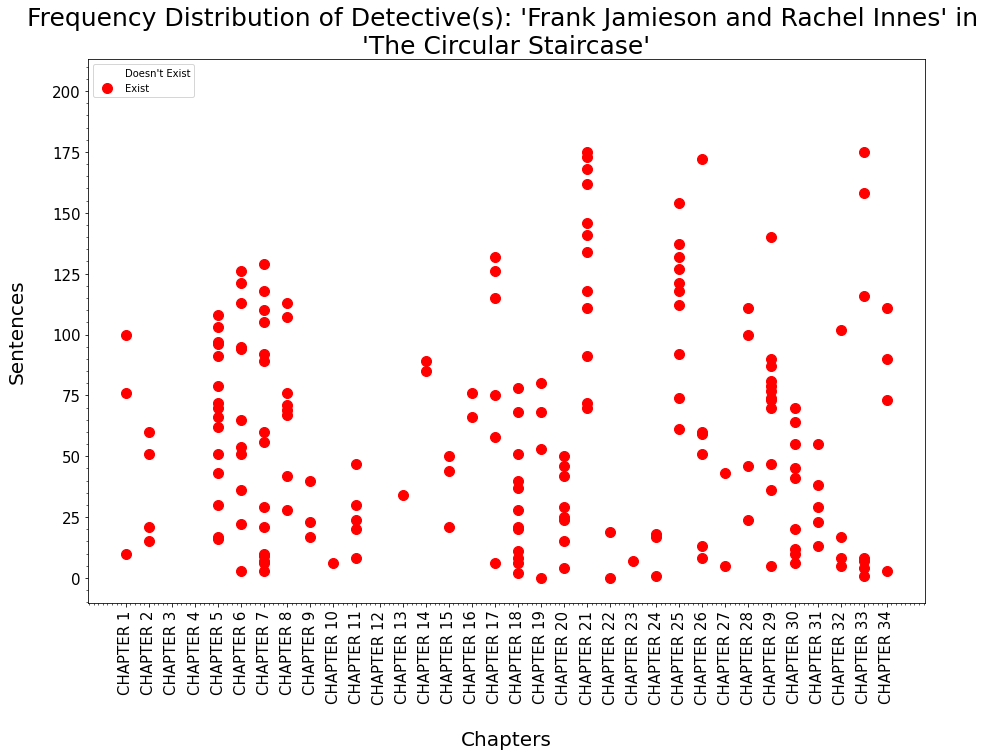

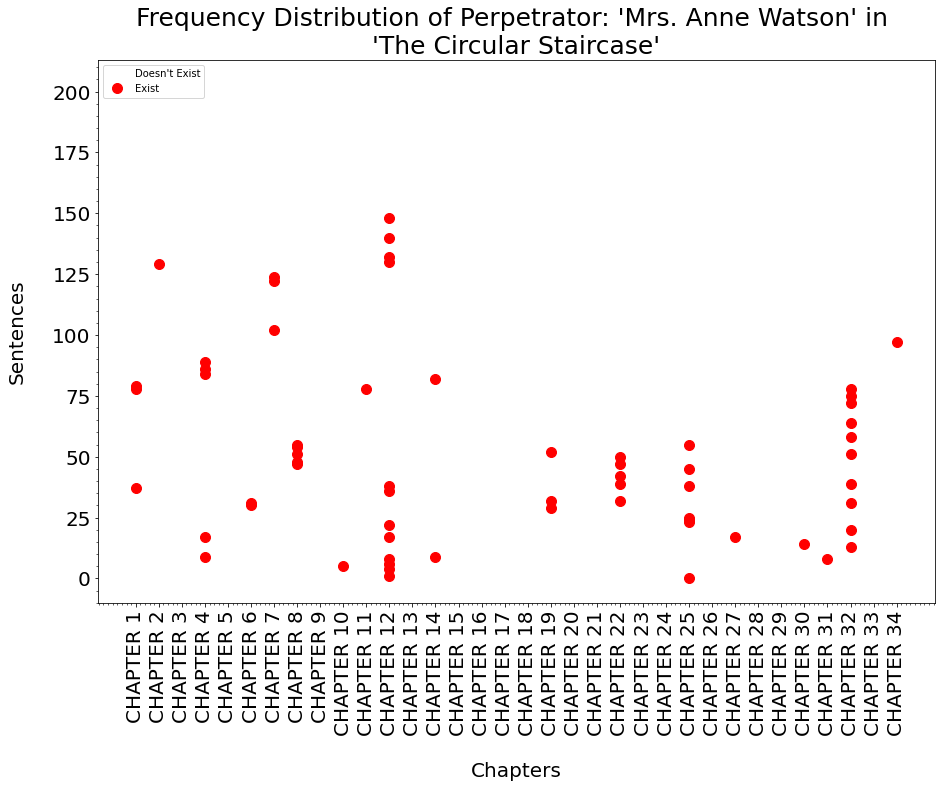

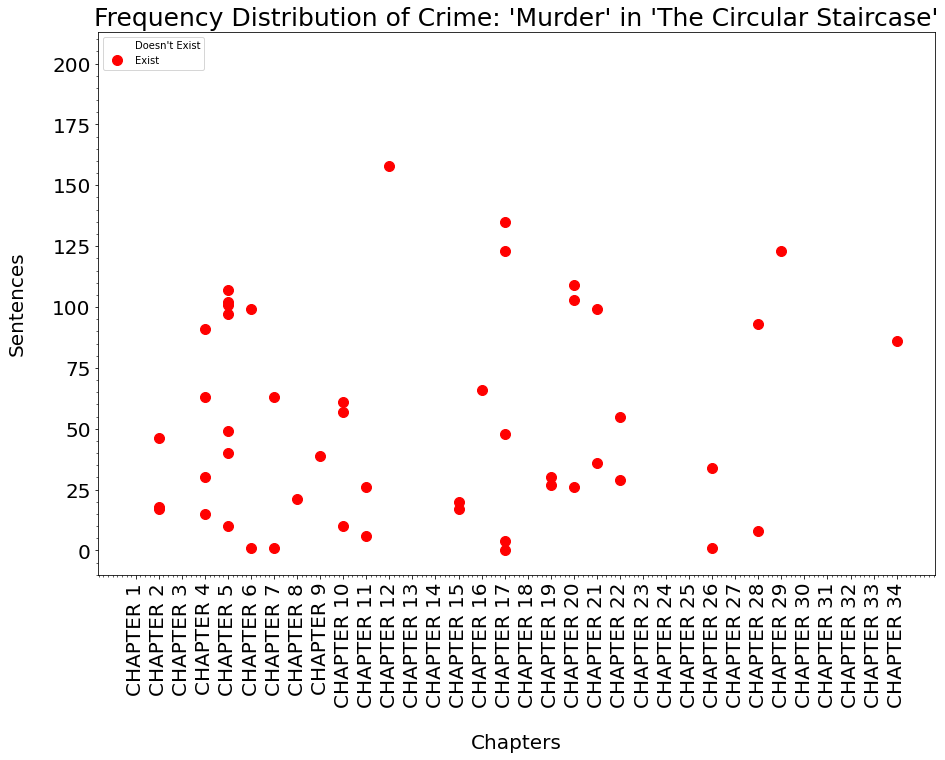

In [51]:
plot_freq_dist(df1[['Chapter', 'Sentence', 'Detective(s): Frank Jamieson and Rachel Innes']],
               'Detective(s): Frank Jamieson and Rachel Innes', "Detective(s): 'Frank Jamieson and Rachel Innes' in \n'The Circular Staircase'")
plot_freq_dist(df1[['Chapter', 'Sentence', 'Perpetrator: Mrs. Anne Watson']],
               'Perpetrator: Mrs. Anne Watson', "Perpetrator: 'Mrs. Anne Watson' in \n'The Circular Staircase'")
plot_freq_dist(df1[['Chapter', 'Sentence', 'Crime: Murder']],
               'Crime: Murder', "Crime: 'Murder' in 'The Circular Staircase'")


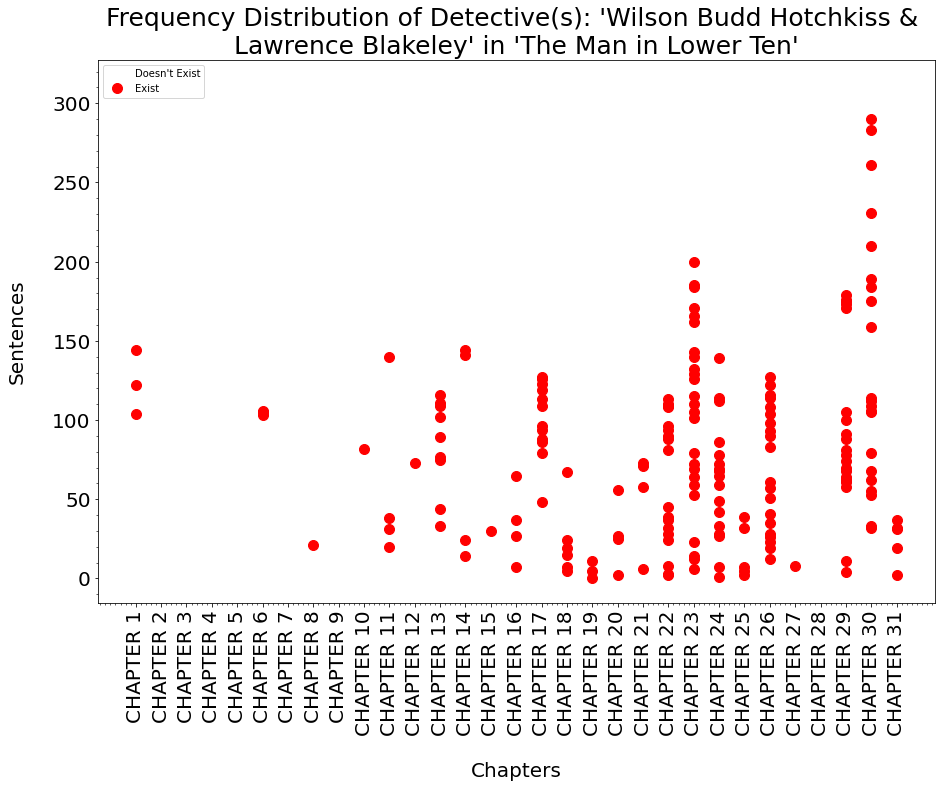

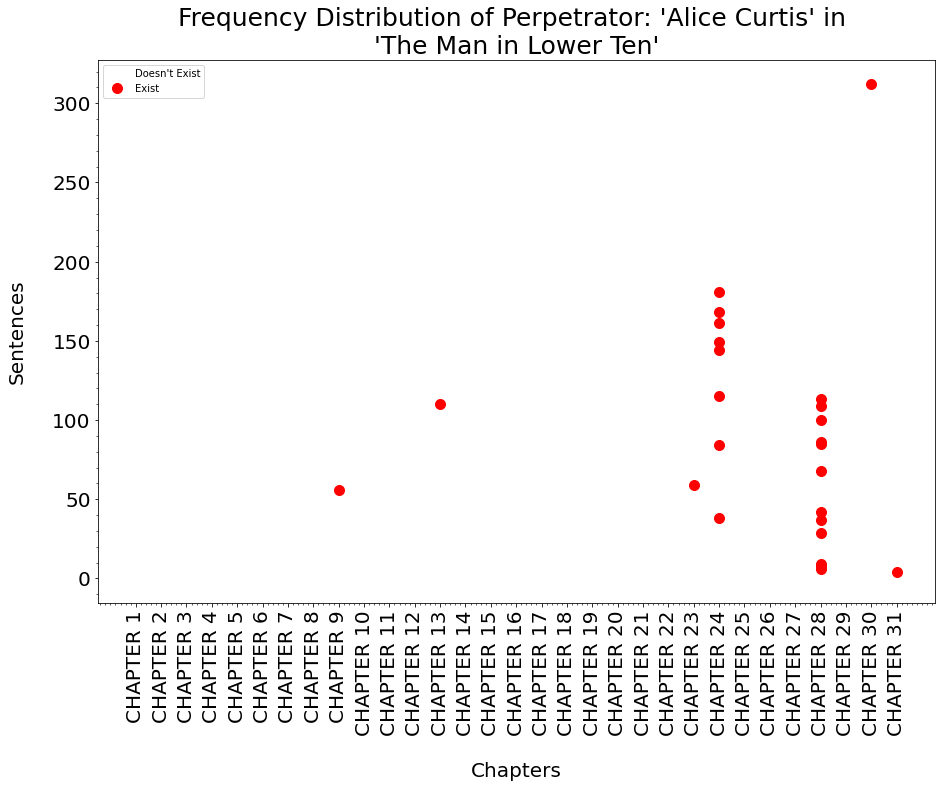

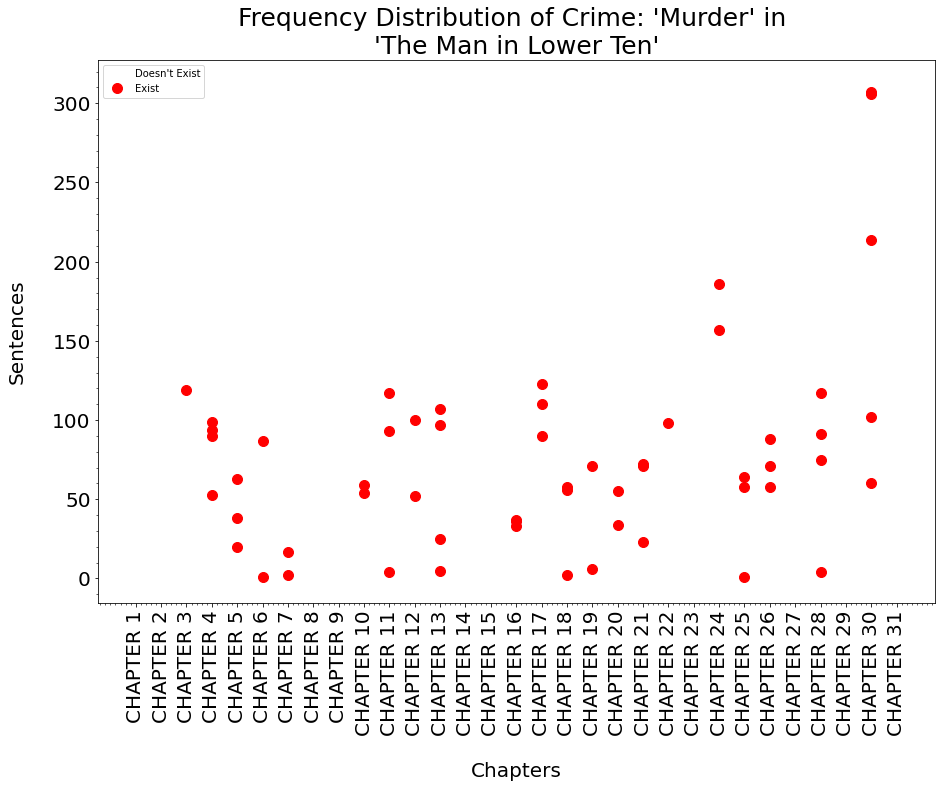

In [52]:
plot_freq_dist(df2[['Chapter', 'Sentence', 'Detective(s): Wilson Budd Hotchkiss & Lawrence Blakeley']],
               'Detective(s): Wilson Budd Hotchkiss & Lawrence Blakeley', "Detective(s): 'Wilson Budd Hotchkiss & \nLawrence Blakeley' in 'The Man in Lower Ten'")
plot_freq_dist(df2[['Chapter', 'Sentence', 'Perpetrator: Alice Curtis']],
               'Perpetrator: Alice Curtis', "Perpetrator: 'Alice Curtis' in \n'The Man in Lower Ten'")
plot_freq_dist(df2[['Chapter', 'Sentence', 'Crime: Murder']],
               'Crime: Murder', "Crime: 'Murder' in \n'The Man in Lower Ten'")

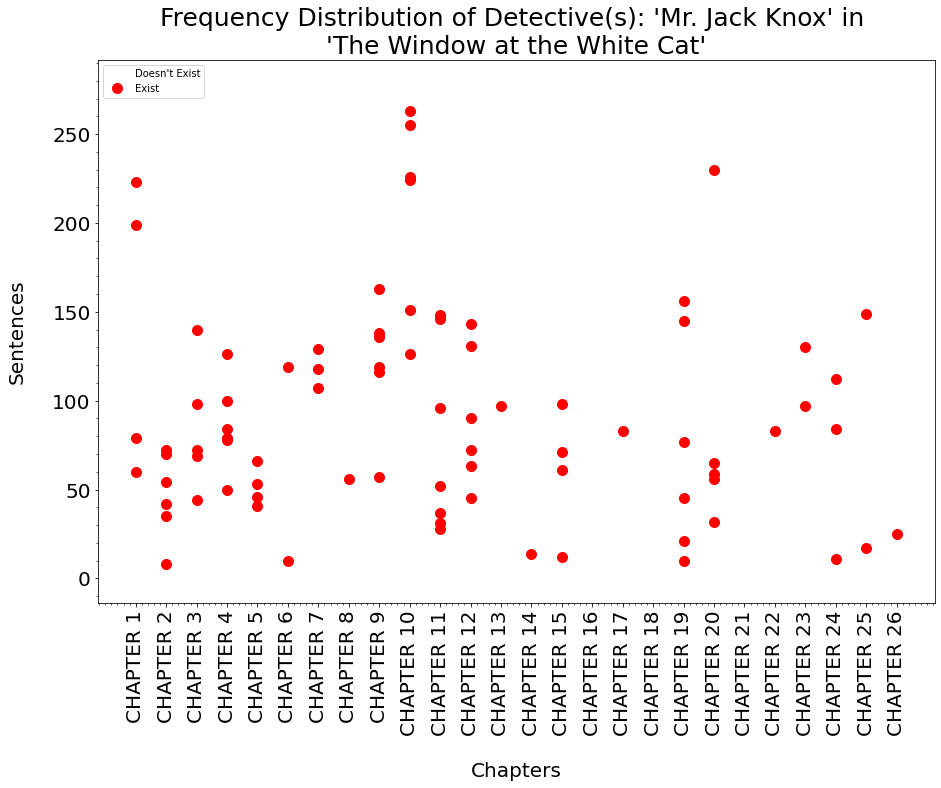

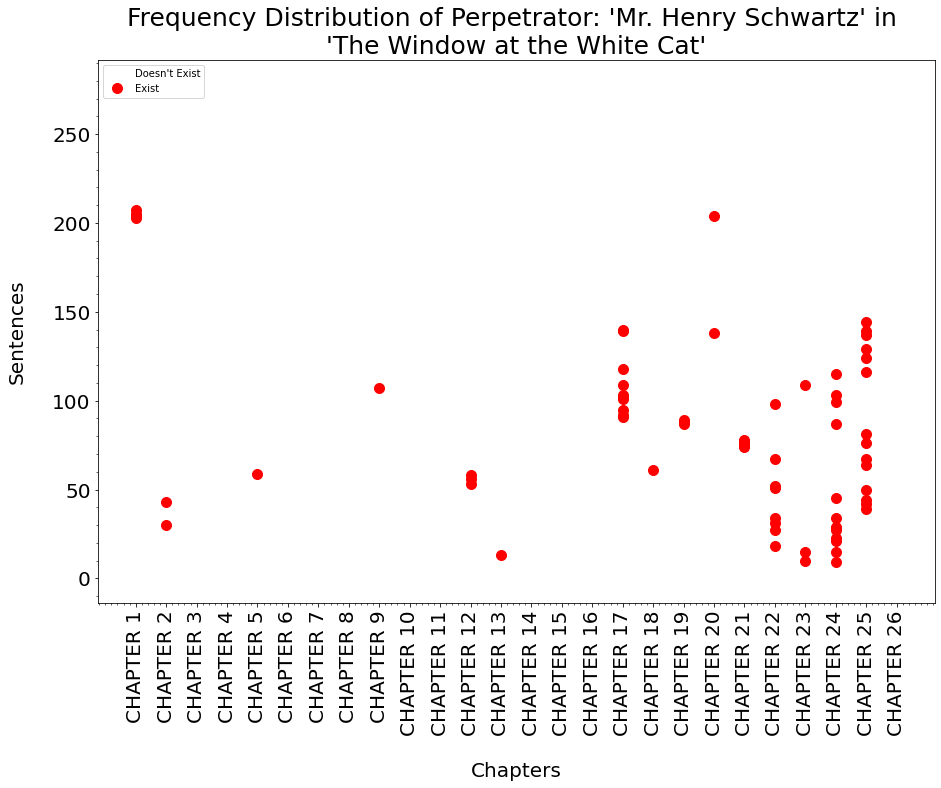

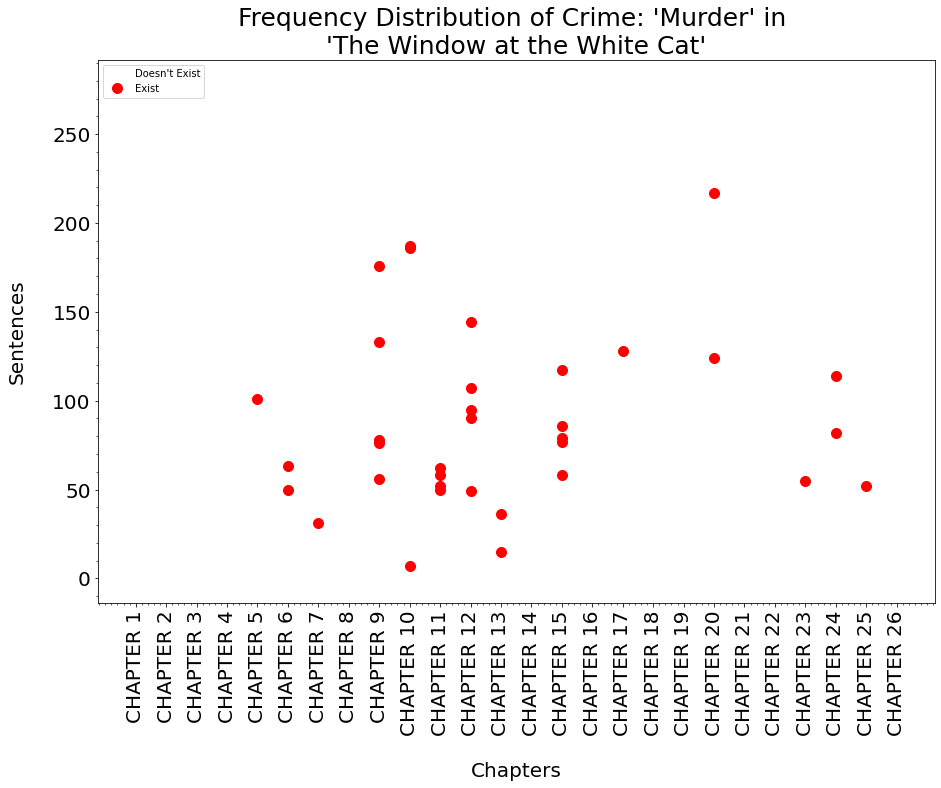

In [53]:
plot_freq_dist(df3[['Chapter', 'Sentence', 'Detective(s): Mr. Jack Knox']],
               'Detective(s): Mr. Jack Knox', "Detective(s): 'Mr. Jack Knox' in \n'The Window at the White Cat'")
plot_freq_dist(df3[['Chapter', 'Sentence', 'Perpetrator: Mr. Henry Schwartz']],
               'Perpetrator: Mr. Henry Schwartz', "Perpetrator: 'Mr. Henry Schwartz' in \n'The Window at the White Cat'")
plot_freq_dist(df3[['Chapter', 'Sentence', 'Crime: Murder']],
               'Crime: Murder', "Crime: 'Murder' in \n'The Window at the White Cat'")

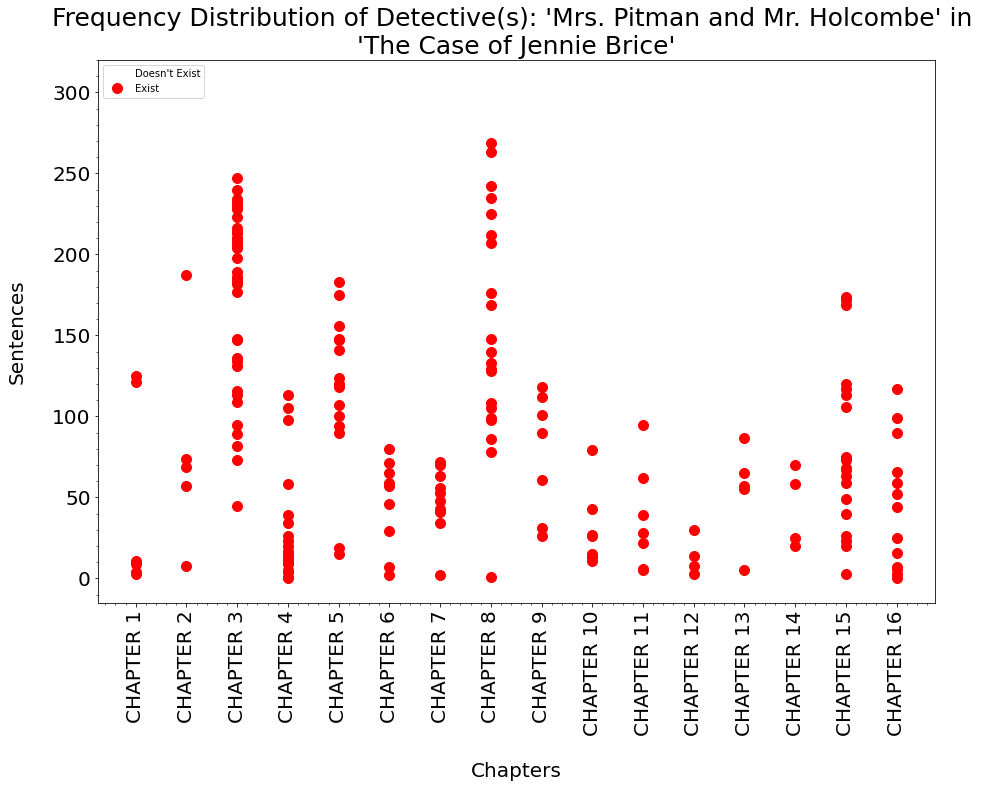

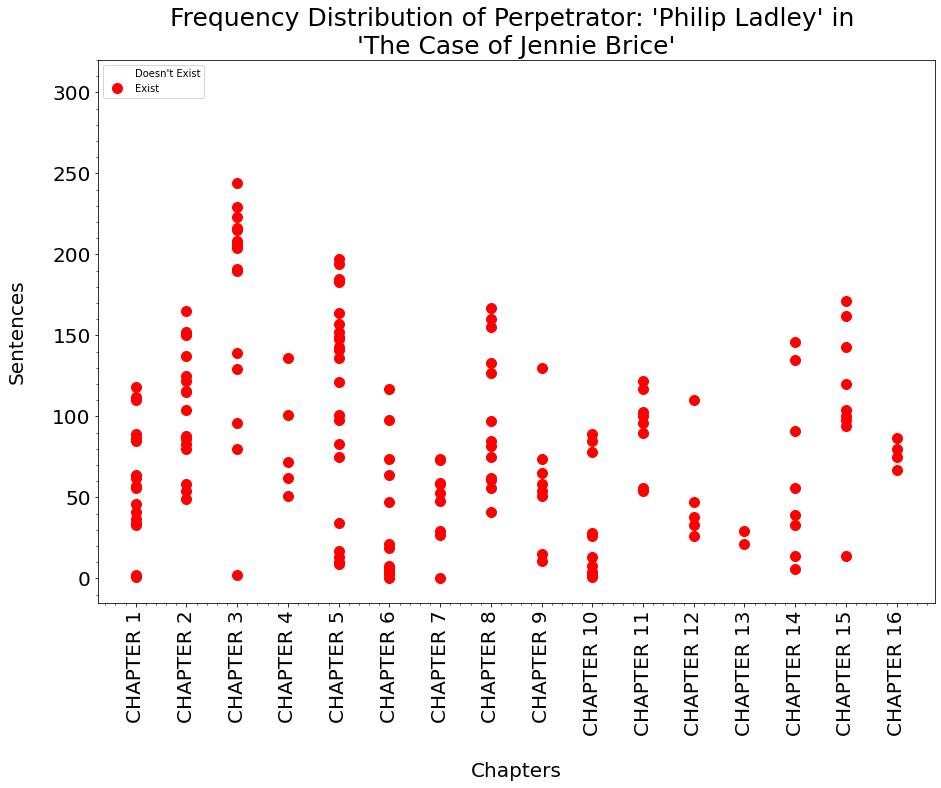

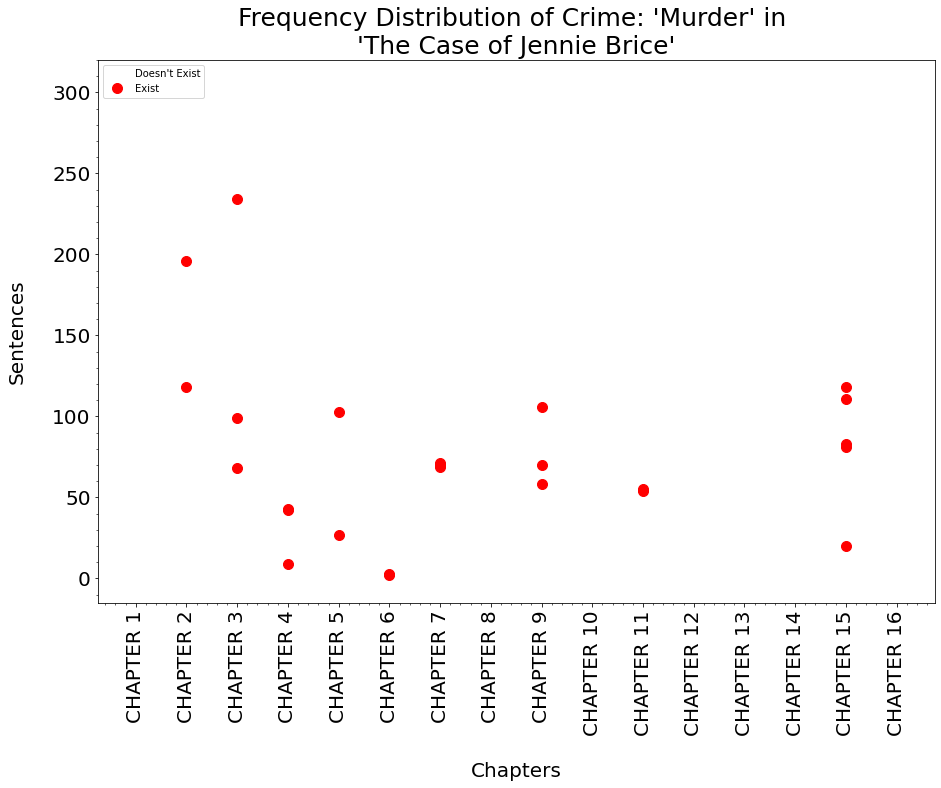

In [54]:
plot_freq_dist(df4[['Chapter', 'Sentence', 'Detective(s): Mrs. Pitman and Mr. Holcombe']],
               'Detective(s): Mrs. Pitman and Mr. Holcombe', "Detective(s): 'Mrs. Pitman and Mr. Holcombe' in \n'The Case of Jennie Brice'")
plot_freq_dist(df4[['Chapter', 'Sentence', 'Perpetrator: Philip Ladley']],
               'Perpetrator: Philip Ladley', "Perpetrator: 'Philip Ladley' in \n'The Case of Jennie Brice'")
plot_freq_dist(df4[['Chapter', 'Sentence', 'Crime: Murder']],
               'Crime: Murder', "Crime: 'Murder' in \n'The Case of Jennie Brice'")

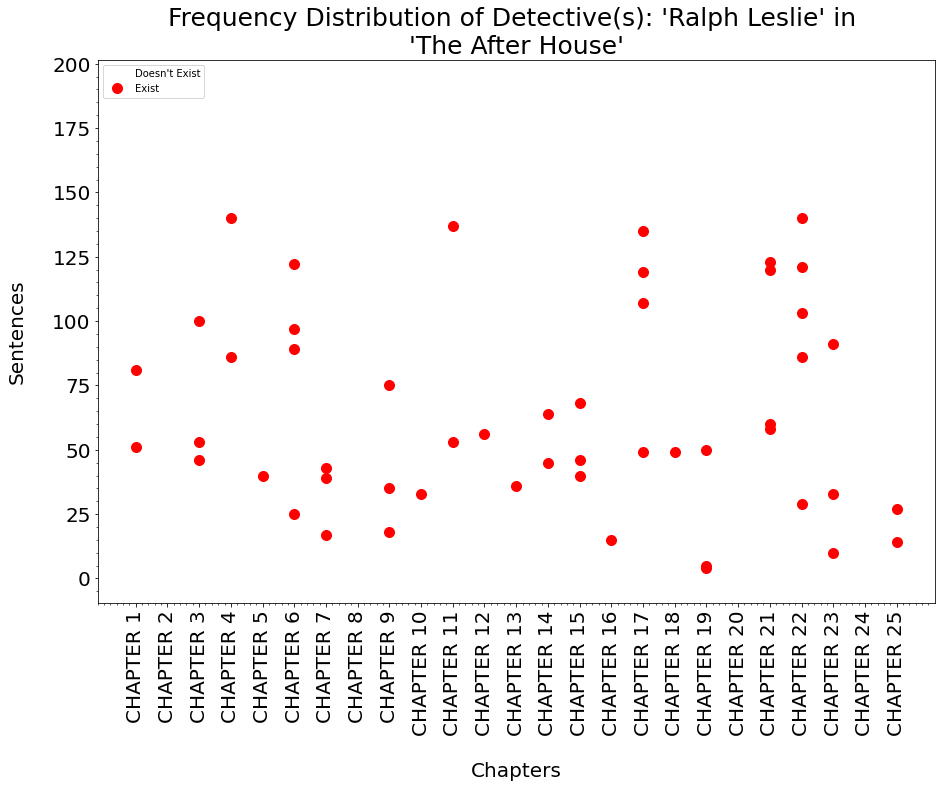

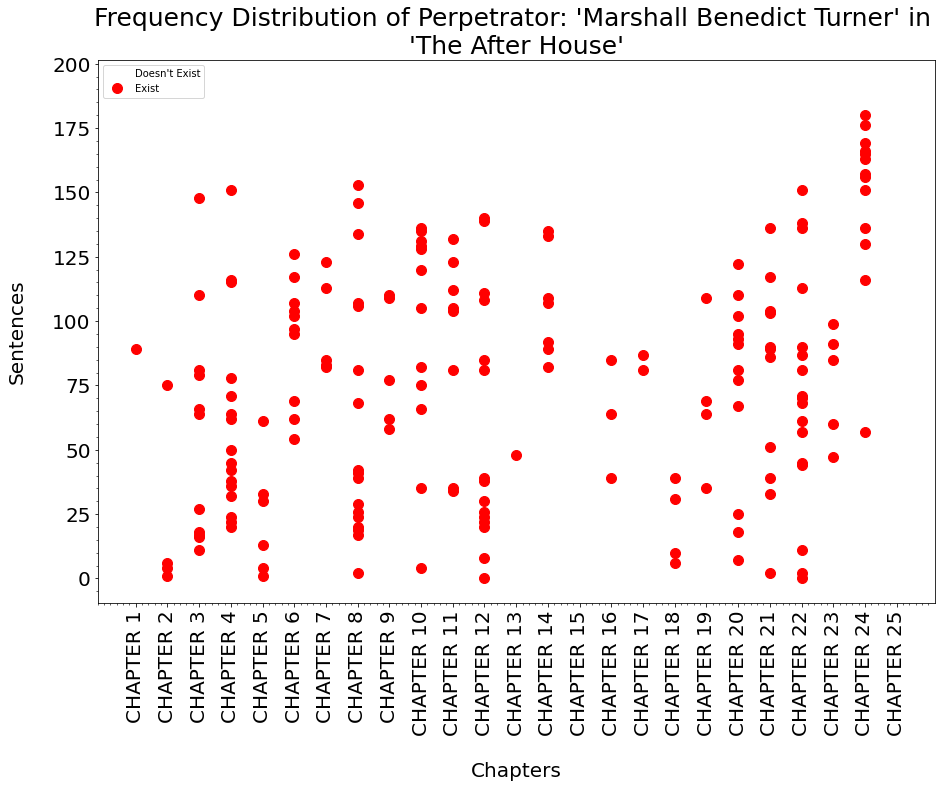

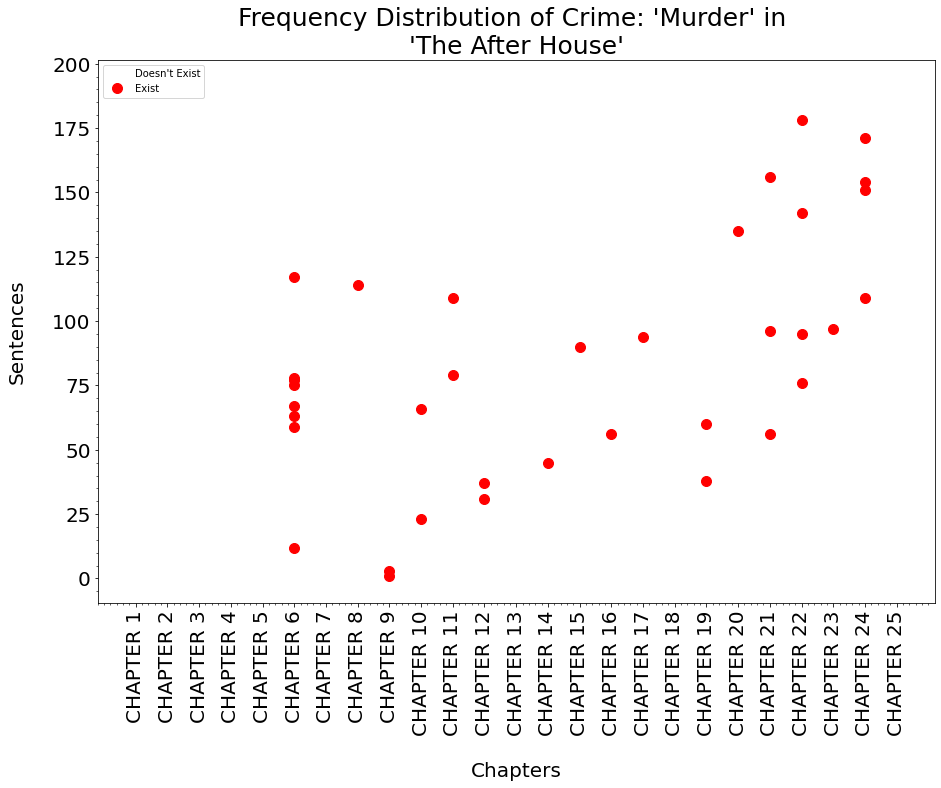

In [55]:
plot_freq_dist(df5[['Chapter', 'Sentence', 'Detective(s): Ralph Leslie']],
               'Detective(s): Ralph Leslie', "Detective(s): 'Ralph Leslie' in \n'The After House'")
plot_freq_dist(df5[['Chapter', 'Sentence', 'Perpetrator: Marshall Benedict Turner']],
               'Perpetrator: Marshall Benedict Turner', "Perpetrator: 'Marshall Benedict Turner' in \n'The After House'")
plot_freq_dist(df5[['Chapter', 'Sentence', 'Crime: Murder']],
               'Crime: Murder', "Crime: 'Murder' in \n'The After House'")

# RegEx vs SpaCy

In [56]:
 # regex
print(word_list1[0][:])

['this', 'is', 'the', 'story', 'of', 'how', 'a', 'middle-aged', 'spinster', 'lost', 'her', 'mind', 'deserted', 'her', 'domestic', 'gods', 'in', 'the', 'city', 'took', 'a', 'furnished', 'house', 'for', 'the', 'summer', 'out', 'of', 'town', 'and', 'found', 'herself', 'involved', 'in', 'one', 'of', 'those', 'mysterious', 'crimes', 'that', 'keep', 'our', 'newspapers', 'and', 'detective', 'agencies', 'happy', 'and', 'prosperous']


In [57]:
# spacy
spacy_nlp = spacy.load('en_core_web_sm')
token_ls = []
for k,v in d1.values():
  doc = spacy_nlp(v)
  tokens = [token.text for token in doc]
  token_ls.append(tokens)
print(token_ls[0])

[' ', 'This', 'is', 'the', 'story', 'of', 'how', 'a', 'middle', '-', 'aged', 'spinster', 'lost', 'her', 'mind', ',', 'deserted', 'her', 'domestic', 'gods', 'in', 'the', 'city', ',', 'took', 'a', 'furnished', 'house', 'for', 'the', 'summer', 'out', 'of', 'town', ',', 'and', 'found', 'herself', 'involved', 'in', 'one', 'of', 'those', 'mysterious', 'crimes', 'that', 'keep', 'our', 'newspapers', 'and', 'detective', 'agencies', 'happy', 'and', 'prosperous', '.', ' ', 'For', 'twenty', 'years', 'I', 'had', 'been', 'perfectly', 'comfortable', ';', 'for', 'twenty', 'years', 'I', 'had', 'had', 'the', 'window', '-', 'boxes', 'filled', 'in', 'the', 'spring', ',', 'the', 'carpets', 'lifted', ',', 'the', 'awnings', 'put', 'up', 'and', 'the', 'furniture', 'covered', 'with', 'brown', 'linen', ';', 'for', 'as', 'many', 'summers', 'I', 'had', 'said', 'good', '-', 'by', 'to', 'my', 'friends', ',', 'and', ',', 'after', 'watching', 'their', 'perspiring', 'hegira', ',', 'had', 'settled', 'down', 'to', 'a', 

# Sentiment Analysis

In [63]:
import pandas as pd
import numpy as np
from collections import defaultdict

# Set Pandas to display all rows of dataframes
pd.set_option('display.max_rows', 500)

# nltk
from nltk import tokenize
# !pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Plotting tools
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('fivethirtyeight')
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from tqdm import tqdm_notebook as tqdm
from tqdm import trange

     |████████████████████████████████| 133kB 2.9MB/s 


In [73]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [64]:
analyzer = SentimentIntensityAnalyzer()

In [97]:
sentiment_book = defaultdict(dict)
s = [s1, s2, s3, s4, s5]

for i in range(len(s)):
  for k,v in s[i].items():
    sentiments = {'compound': 0.0, 'neg': 0.0, 'neu': 0.0, 'pos': 0.0}
    sentence_list = list(v)
    for sentence in sentence_list:
      # print(sentence)
      vs = analyzer.polarity_scores(sentence)
      sentiments['compound'] += vs['compound']
      sentiments['neg'] += vs['neg']
      sentiments['neu'] += vs['neu']
      sentiments['pos'] += vs['pos']
        
    sentiments['compound'] = sentiments['compound'] / len(sentence_list)
    sentiments['neg'] = sentiments['neg'] / len(sentence_list)
    sentiments['neu'] = sentiments['neu'] / len(sentence_list)
    sentiments['pos'] = sentiments['pos'] / len(sentence_list)
    # print(sentiments)
    sentiment_book[novel_ls[i]][k] = sentiments['compound']
sentiment_book = dict(sentiment_book)
# sentiment_book

{'The After House (1914)': {'CHAPTER 1': 0.11333333333333334,
  'CHAPTER 10': -0.10923333333333334,
  'CHAPTER 11': 0.0,
  'CHAPTER 12': -0.23013333333333333,
  'CHAPTER 13': -0.22693333333333332,
  'CHAPTER 14': -0.2526333333333333,
  'CHAPTER 15': 0.0,
  'CHAPTER 16': 0.0,
  'CHAPTER 17': 0.1468,
  'CHAPTER 18': -0.1468,
  'CHAPTER 19': -0.18213333333333334,
  'CHAPTER 2': 0.0,
  'CHAPTER 20': 0.0,
  'CHAPTER 21': 0.0,
  'CHAPTER 22': 0.0,
  'CHAPTER 23': 0.19510000000000002,
  'CHAPTER 24': 0.20753333333333335,
  'CHAPTER 25': 0.1998,
  'CHAPTER 3': 0.0,
  'CHAPTER 4': 0.0,
  'CHAPTER 5': 0.11333333333333334,
  'CHAPTER 6': -0.19063333333333332,
  'CHAPTER 7': -0.17020000000000002,
  'CHAPTER 8': 0.0,
  'CHAPTER 9': -0.3473333333333333},
 'The Case of Jennie Brice (1913)': {'CHAPTER 1': -0.10236666666666666,
  'CHAPTER 10': 0.0,
  'CHAPTER 11': 0.0,
  'CHAPTER 12': 0.07543333333333334,
  'CHAPTER 13': -0.3552666666666666,
  'CHAPTER 14': 0.0,
  'CHAPTER 15': -0.047633333333333326,
 

In [102]:
book_indices = {}
idx = 0
for book in sentiment_book:
    start = idx
    for chapter in sentiment_book[book]:
        idx += 1
    book_indices[book] = (start, idx)
book_indices

{'The After House (1914)': (107, 132),
 'The Case of Jennie Brice (1913)': (91, 107),
 'The Circular Staircase (1908)': (0, 34),
 'The Man in Lower Ten (1909)': (34, 65),
 'The Window at the White Cat (1910)': (65, 91)}

In [100]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

<Figure size 1440x576 with 0 Axes>

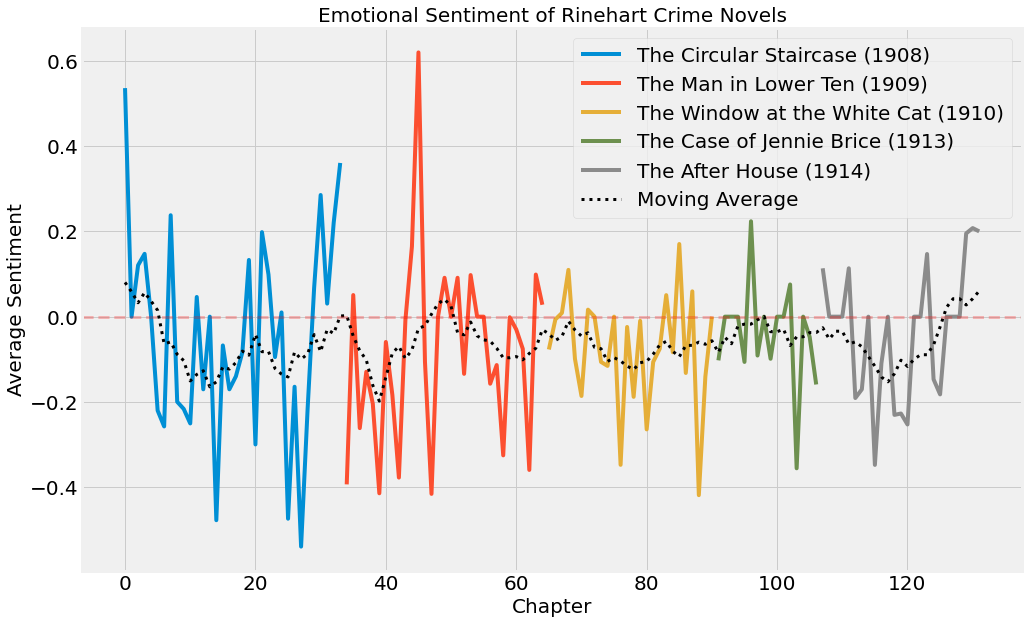

In [137]:
plt.figure(figsize=(20,8))
# figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
length = sum([len(sentiment_book[book]) for book in sentiment_book])
x = np.linspace(0, length - 1, num=length)
y = [sentiment_book[book][chapter] for book in sentiment_book for chapter in sentiment_book[book]]
x_pos = [v[0] for d in [d1,d2,d3,d4,d5] for v in d.values()]
plt.figure(figsize=(15, 10))
for book in book_indices:
    plt.plot(x[book_indices[book][0]: book_indices[book][1]],
             y[book_indices[book][0]: book_indices[book][1]],
             label=book)
plt.plot(movingaverage(y, 10), color='k', linewidth=3, linestyle=':', label = 'Moving Average')
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)
plt.legend(loc='best', fontsize=20)
plt.title('Emotional Sentiment of Rinehart Crime Novels', fontsize=20)
plt.xlabel('Chapter', fontsize=20)
plt.ylabel('Average Sentiment', fontsize=20)
# plt.xticks(x, x_pos, rotation = 90, fontsize = 7)
plt.show()

# ------------THE END-------------------


In [58]:
# def make_df(d):
#   num = []
#   title = []
#   content = []
#   for key,val in d.items():
#       num.append(key)
#       title.append(val[0])
#       content.append(val[1])
#   df_dict = {'chapter_number': num, 'chapter_content': content}
#   df = pd.DataFrame(df_dict, columns = ['chapter_number', 'chapter_title', 'chapter_content'])
#   return df
# df1 = make_df(d1)
# df1.head(5)
# df2 = make_df(d2)
# df2.head(5)
# df3 = make_df(d3)
# df3.head(5)
# df4 = make_df(d4)
# df2.head(4)
# df5 = make_df(d5)
# df5.head(5)

In [59]:
# pd.set_option('display.max_columns', None)  
# pd.set_option('display.expand_frame_repr', False)
# pd.set_option('max_colwidth', 800)

# def nbd_df_maker(nbd_dict):
#   chap_ls = []
#   cont_ls = []
#   for key, value in nbd_dict.items():
#     if value[1]:
#       for v in value[1]:
#         chap_ls.append(key)
#         cont_ls.append([s for s in v])
#   data = {'CHAPTER NO':chap_ls, '6 CONTEXT WORDS AROUND PERPETRATOR':cont_ls}
#   df = pd.DataFrame(data)
#   return df


In [60]:
# with open('circular', 'wb') as fp:
#     pickle.dump(word_list1, fp)
# with open('window', 'wb') as fp:
#     pickle.dump(word_list2, fp)
# with open('jennie', 'wb') as fp:
#     pickle.dump(word_list3, fp)
# with open('after', 'wb') as fp:
#     pickle.dump(word_list4, fp)
# with open('poor', 'wb') as fp:
#     pickle.dump(word_list5, fp)
    

# with open ('circular', 'rb') as fp:
#     w1 = pickle.load(fp)

In [61]:
# import nltk
# nltk.download('stopwords')
# from nltk.corpus import stopwords
# stopwords = nltk.corpus.stopwords.words('english')
# newStopWords = ['im', 'mr', 'mrs', 'miss']
# stopwords.extend(newStopWords)
# no_stopwords=[i for i in word_list if i not in stopwords]
# # no_stopwords